In [1]:
from Model import Model
import pandas as pd
import numpy as np
import itertools
import math
import shap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,OrdinalEncoder
import sys
import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

In [2]:
model_rf = Model('ranf')

In [3]:
X,Y = model_rf.preprocessing.load_data('../../Frame_Analysis/Microsoft Ad Optimization-AI Data_Survey Aggregated Data 19062019.xlsx',labels=False,sheet_name="Sheet2")
X = X[X['Country']== 'US']
Y = X[['Interest Trace']]

FileNotFoundError: [Errno 2] No such file or directory: '../../Frame_Analysis/Microsoft Ad Optimization-AI Data_Survey Aggregated Data 19062019.xlsx'

In [5]:
X.loc[X['Scene Attributes'].isna(),"Scene Attributes"] = "nan"

In [6]:
attr=[]
for val in X['Scene Attributes'].values:
    attr.extend(val.split(','))

In [7]:
set_attr = list(set(attr))
set_attr.remove('nan')
scene_attr = pd.DataFrame(columns=set_attr)
scene_attr['scene_attr'] = X['Scene Attributes']
scene_attr = scene_attr.set_index(X.index)

In [8]:
i=1
for i,val in enumerate(X['Scene Attributes']):
    if val.split(',')[0] != "nan":
        scene_attr.loc[X.index.values[i],val.split(',')] = 1
    sys.stdout.write('\r'+str(i))
    i+=1

5330

In [9]:
scene_attr = scene_attr.drop(['scene_attr'],1)

In [10]:
'nan' in scen

studying semi-enclosed area cloth snow pavement horizontal components  \
0      NaN                NaN   NaN  NaN      NaN                   NaN   
1      NaN                NaN     1  NaN      NaN                   NaN   
2      NaN                NaN     1  NaN      NaN                   NaN   
3      NaN                NaN     1  NaN      NaN                   NaN   
4      NaN                NaN     1  NaN      NaN                   NaN   

  competing glass asphalt eating  ...  dry natural shopping sand brick  \
0       NaN   NaN     NaN    NaN  ...  NaN       1      NaN  NaN   NaN   
1       NaN   NaN     NaN    NaN  ...  NaN     NaN      NaN  NaN   NaN   
2       NaN   NaN     NaN    NaN  ...  NaN     NaN      NaN  NaN   NaN   
3       NaN   NaN     NaN    NaN  ...  NaN     NaN      NaN  NaN   NaN   
4       NaN   NaN     NaN    NaN  ...  NaN     NaN      NaN  NaN   NaN   

  conducting business transporting gaming natural light biking  
0                 NaN            1    NaN           NaN    NaN  
1                 NaN          NaN    NaN           NaN    NaN  
2                 NaN          NaN    NaN           NaN    NaN  
3                 NaN          NaN    NaN           NaN    NaN  
4                 NaN          NaN    NaN           NaN    NaN  

[5 rows x 88 columns]

In [11]:
features = ['length_of_ad_15','ad_type_tv','Age','Gender','Emotion','Ethnicity',
            'Microsoft-Logo','Intel_Logo','Sub-Brands','Other-text',
            'Object 1-Laptop','object 2- Tablet','object 3-Mobile','object 4-PC']

In [12]:
class_dict ={}
le = LabelEncoder()

In [13]:
X_new = pd.DataFrame()
X_new['Video Name'] = X['Video Name']
X_new = X_new.set_index(X.index)

In [14]:
def dur_division(x):
#     print(1,x)
    for i in range(0,10):
        if x['Ocr']/x['Length_of_ad'] <= (i+1)*0.1 and x['Ocr']/x['Length_of_ad'] >= (i)*0.1:
            x['Ocr'] = i
    if x['Ocr']/x['Length_of_ad'] >= 1:
        x['Ocr'] = 9
    return x

In [15]:
X_new['Ocr'] = X['Image Name'].apply(lambda x:float(x.split('_')[-1].replace('.jpg','')))
X_new['Length_of_ad'] = X['Length of the Ad']
X_new = X_new.apply(dur_division,axis=1)
X_new = X_new.drop('Length_of_ad',1)

In [16]:
X.loc[X['Microsoft_Logo'].isna(),'Microsoft_Logo'] = 0
X.loc[X['Microsoft_Logo']=='-','Microsoft_Logo'] = 0

In [17]:
arr = ["Laptop","Tablet","Mobile","PC"]
for i,c in enumerate(['Object 1-Laptop','object 2- Tablet','object 3-Mobile','object 4-PC']):
    X.loc[X[c]=="Yes",c] = arr[i]
    X.loc[X[c]=="yes",c] = arr[i]
    X.loc[X[c]=="No",c] = float('nan')
    X.loc[X[c]==" ",c] = float('nan')

In [18]:
X_new['length_of_ad_30'] = le.fit_transform(X['Length of the Ad'])
class_dict['length_of_ad_30'] = le.classes_
X_new['ad_type_tv'] = le.fit_transform(X['AD Type: TV/DIGITAL'])
class_dict['ad_type_tv'] = le.classes_

In [19]:
def separate(x,i):
    if x == 'No Face Found':
        return "nan"
    else:
        return np.array(x.replace('[','').replace(']','').replace("'",'').split(','))[i]

In [20]:
X['Age'] = X['Age-Gender'].apply(lambda x: separate(x,0))
X['Gender'] = X['Age-Gender'].apply(lambda x: separate(x,1))
X_new['microsoft_logo'] = X['Microsoft_Logo']

In [21]:
ohe = OneHotEncoder()

In [22]:
# data = ohe.fit_transform(np.reshape(X_new['Ocr'].values,(-1,1))).toarray()
# class_ = ['frame_0_25','frame_25_50','frame_50_75','frame_75_100']
# for c in ohe.categories_[0]:
#     X_new[class_[int(c)]] = data[:,int(c)]
# X_new = X_new.drop('Ocr',1)

In [23]:
for col in features[2:]:
    X[col] = X[col].apply(lambda x: "nan" if isinstance(x,type(float('nan'))) else x.lower())
    data = ohe.fit_transform(np.reshape(X[col].values,(-1,1))).toarray()  
    for i,unique_col in enumerate(ohe.categories_[0]):
        if unique_col != 'nan' and unique_col !='no face found' :
            X_new[unique_col] = data[:,i]
#     class_dict[col] = le.classes_

In [24]:
X_new = pd.concat((X_new,scene_attr),axis=1)

In [25]:
X_new = X_new.fillna(0)

In [26]:
# new_features =[["happiness",' female'],["surprise"," male"],["neutral"," male"],["happiness","age: 0-5"],["disgust","age: 45-60"],["surprise","age: 0-5"],["neutral","age: 25-34"],["happiness","eastasian"],["surprise","eastasian"]]
# age_cols = ['age: 0-15', 'age: 0-5', 'age: 15-24','age: 25-34', 'age: 35-44', 'age: 45-60']
# ethinicity_cols = ['african', 'caucasian', 'eastasian','latino']
# age_ethinicity_col = list(itertools.product(age_cols,ethinicity_cols))
# new_features.extend(age_ethinicity_col)
# for f1,f2 in new_features:
#     X_new[f1+'_'+f2] = X_new[f1]+X_new[f2]
#     X_new[X_new[f1+'_'+f2] == 1] = 0
#     X_new[X_new[f1+'_'+f2] == 2] = 1
# X_new['happiness_length_of_ad_impact'] = X_new['happiness'] * (1-X_new['length_of_ad_15'])

In [27]:
# for col in features[2:]:
#     X_new[col] = le.fit_transform(X[col].apply(lambda x: "nan" if isinstance(x,type(float('nan'))) else x.lower()))
# #     data = ohe.fit_transform(np.reshape(X[col].values,(-1,1))).toarray()  
# #     for i,unique_col in enumerate(ohe.categories_[0]):
# #         if unique_col != 'nan' and unique_col !='no face found' :
# #             X_new[unique_col] = data[:,i]
#     class_dict[col] = le.classes_

In [28]:
X_new.columns.values

array(['Video Name', 'Ocr', 'length_of_ad_30', 'ad_type_tv',
       'microsoft_logo', 'age: 0-15', 'age: 0-5', 'age: 15-24',
       'age: 25-34', 'age: 35-44', 'age: 45-60', ' female', ' male',
       'angry', 'disgust', 'fear', 'happiness', 'neutral', 'sadness',
       'surprise', 'african', 'caucasian', 'eastasian', 'latino',
       'microsoft', 'intel', 'asus t102', 'dell pcs', 'dell xps 13',
       'hp spectre x360', 'hp spectre x360, windows', 'lenovo yoga 720',
       'lenovo yoga 910', 'macbook air', 'macbook pro',
       'microsoft surface', 'suface laptop', 'surface book', 'surface go',
       'surface laptop', 'surface pen', 'surface pro', 'surface pro 4',
       'surface pro 4, apple_macbookair13',
       'surface pro 4, hp spectre x360', 'surface pro 4, macbook air',
       'surface pro 4, macbook air13, macbook air',
       'surface pro 4, surface book', 'surface pro 4, windows 10',
       'surface pro 6', 'the new surface pro', 'the surface laptop',
       'windows', 'win

In [29]:
len(X_new.columns.values)

156

In [30]:
X_new[['microsoft_logo']] = X_new['microsoft_logo'].astype('float')

In [31]:
ocr=X_new[['Ocr']]
X_new = X_new.drop(['length_of_ad_30','ad_type_tv','Ocr'],1)

In [32]:
X_train,X_test,y_train,y_test = train_test_split(X_new,Y,test_size=0.3,random_state=123)

In [33]:
# resize = (pd.concat((X_train,y_train),axis=1)['Interest Trace']>10).sum()
# X_train['labels'] = (pd.concat((X_train,y_train),axis=1)['Interest Trace']<10)
# X_train['labels'] = X_train['labels'].astype('int')
# X_res,y_res = model_rf.preprocessing.overSampling(X_train,y_train,col_as_label='labels',each_Col=False,rmCols=['Video Name','labels'],size=2*resize,random_state=12)
# X_res = X_res.drop('labels',1)

In [34]:
print("------------------------ RF Model Training ----------------------------\n")
trained_rf = model_rf.train(X_train,y_train,X_test,y_test,metrics='r2',set_params=True,params={'Interest Trace':{'bootstrap': False, 'max_depth': 15, 'max_features': 0.3, 'min_samples_leaf': 2, 'n_estimators': 300}},plot_error=False)

------------------------ RF Model Training ----------------------------

Interest Trace


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.7s remaining:    7.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


For training set
r2_score: 0.415863
For test set
r2_score: 0.448675




[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.1s finished


Interest Trace
Feature ranking:
scary
transporting
microsoft_logo
cloth
ocean
working
wood
horizontal components
natural light
vertical components
plastic
natural
indoor lighting
laptop
dry
matte
microsoft
glossy
far-away horizon
tablet
enclosed area
metal
paper
neutral
age: 25-34
brick
competing
reading
glass
caucasian
spectating
open area
surprise
training
age: 15-24
 male
eastasian
congregating
warm
african
 female
sports
cold
happiness
dell xps
age: 35-44
socializing
studying
still water
stressful
windows 10
exercise
surface pro 6
age: 0-5
windows 10 pcs
driving
no horizon
surface book
cluttered space
clouds
research
sadness
surface pen
man-made
latino
age: 45-60
asphalt
aged
hp
hp spectre x360, windows
sunny
tiles
shopping
vinyl
surface go
playing
using tools
surface laptop
sterile
vegetation
boating
swimming
carpet
diving
touring
trees
sand
surface pro 4, hp spectre x360
surface pro 4
eating
soothing
grass
foliage
moist
snow
leaves
praying
the new surface pro
conducting business


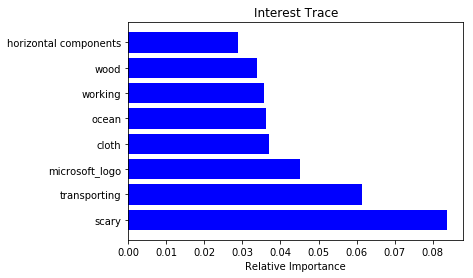

In [35]:
model_rf.plot_feature_importance(trained_rf,10,y_test.columns,X_test.columns.values[1:])

## Stacked Bar Chart

In [36]:
# explainer_dt= shap.TreeExplainer(trained_rf[0])
# shap_values_dt= explainer_dt.shap_values(X_train.drop('Video Name',1))

In [81]:
import matplotlib.pyplot as plt
col = X_new.drop('Video Name',1).columns.values

features = ['scary','transporting','microsoft_logo','ocean','wood','cloth','working',
 'horizontal components','natural light','indoor lighting','plastic','vertical components','laptop']
index = [i for i in range(col.shape[0]) if col[i] in features]

X_new['Ocr'] = ocr.loc[X_new.index,'Ocr']

In [82]:
np.unique(ocr)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [83]:
videos=[]
video_groups = X_new.groupby(['Video Name'])
for key in video_groups.groups.keys():
    videos.append(video_groups.get_group(key))


In [84]:
explainer_dt= shap.TreeExplainer(trained_rf[0])
from tqdm import tqdm 





  0%|          | 0/109 [00:00<?, ?it/s]



  1%|          | 1/109 [00:10<18:20, 10.19s/it]



  2%|▏         | 2/109 [00:15<15:33,  8.73s/it]



  3%|▎         | 3/109 [00:20<13:34,  7.69s/it]



  4%|▎         | 4/109 [00:23<10:54,  6.23s/it]



  5%|▍         | 5/109 [00:26<09:05,  5.25s/it]



  6%|▌         | 6/109 [00:31<09:05,  5.29s/it]



  6%|▋         | 7/109 [00:37<09:02,  5.32s/it]



  7%|▋         | 8/109 [00:42<09:03,  5.38s/it]



  8%|▊         | 9/109 [00:48<09:00,  5.41s/it]



  9%|▉         | 10/109 [00:53<08:53,  5.39s/it]



 10%|█         | 11/109 [00:59<08:53,  5.44s/it]



 11%|█         | 12/109 [01:02<07:37,  4.71s/it]



 12%|█▏        | 13/109 [01:05<06:44,  4.22s/it]



 13%|█▎        | 14/109 [01:10<07:14,  4.57s/it]



 14%|█▍        | 15/109 [01:17<08:22,  5.34s/it]



 15%|█▍        | 16/109 [01:23<08:16,  5.34s/it]



 16%|█▌        | 17/109 [01:28<08:06,  5.29s/it]



 17%|█▋        | 18/109 [01:33<08:00,  5.28s/it]



 17%|█▋        | 19/109 [0

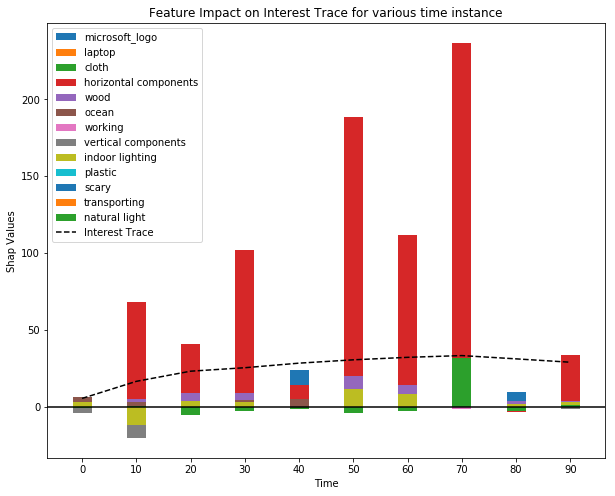

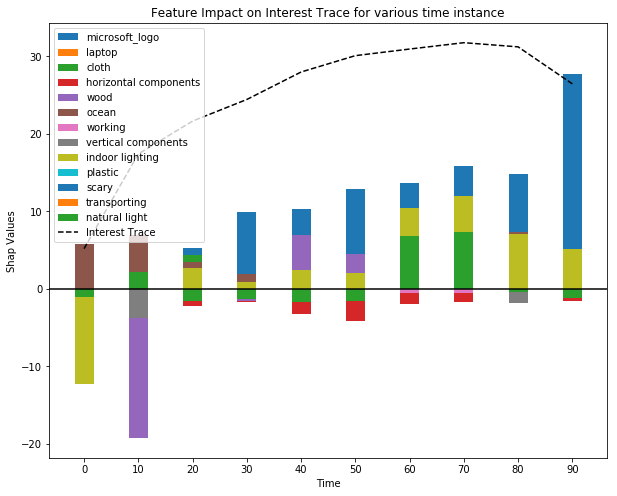

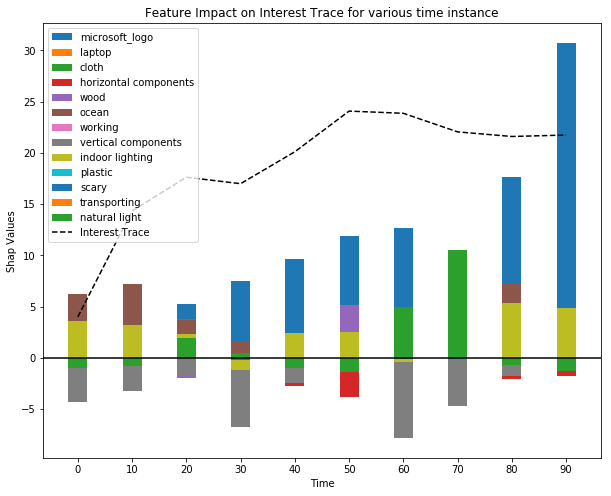

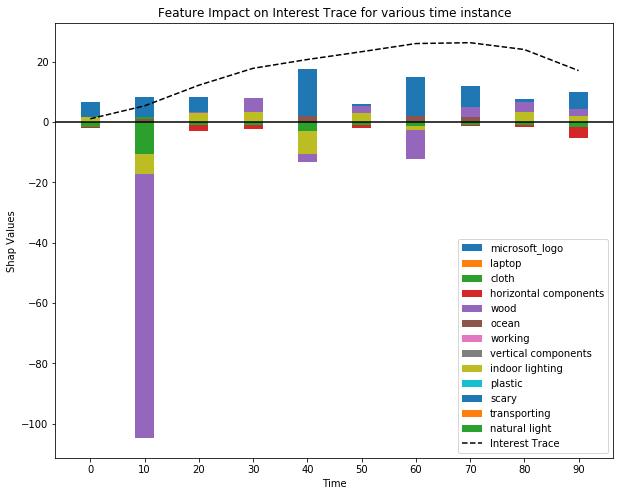

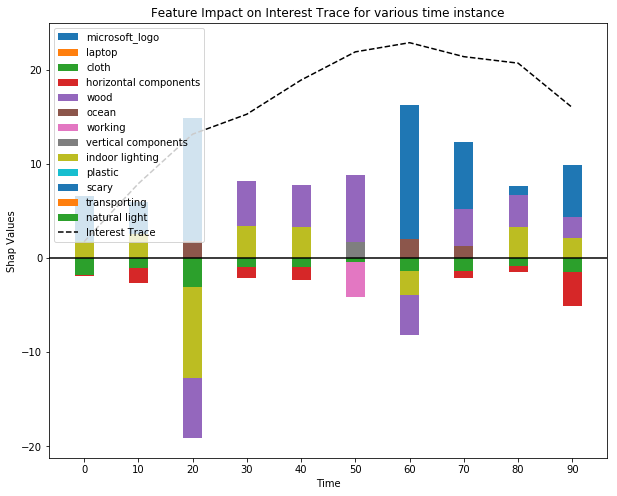

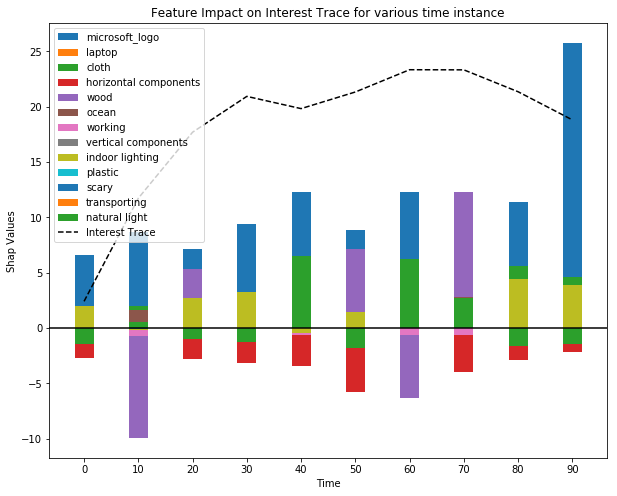

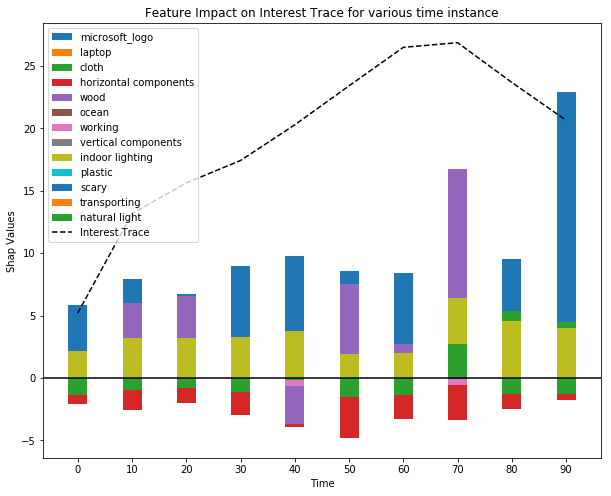

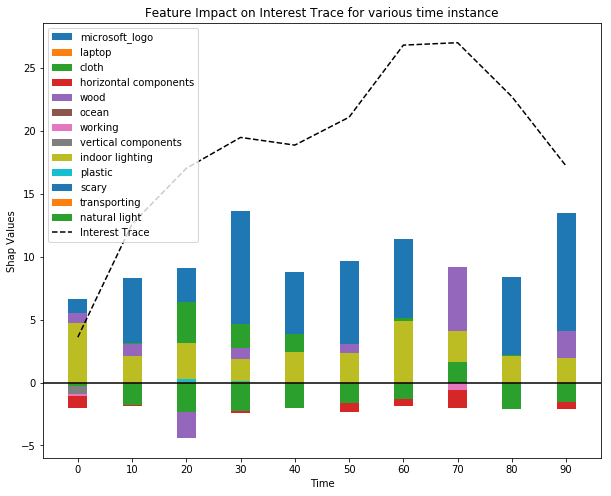

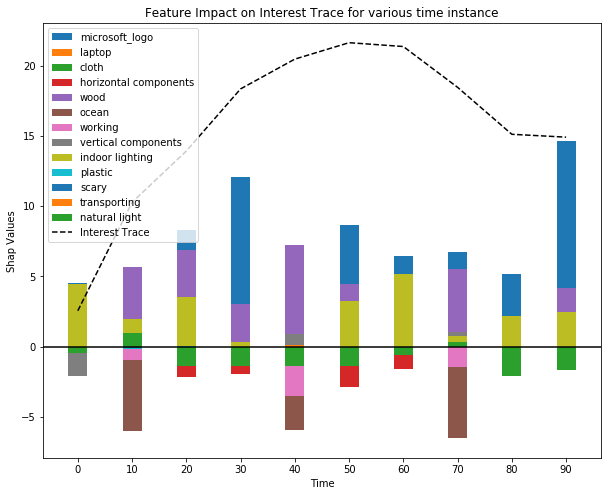

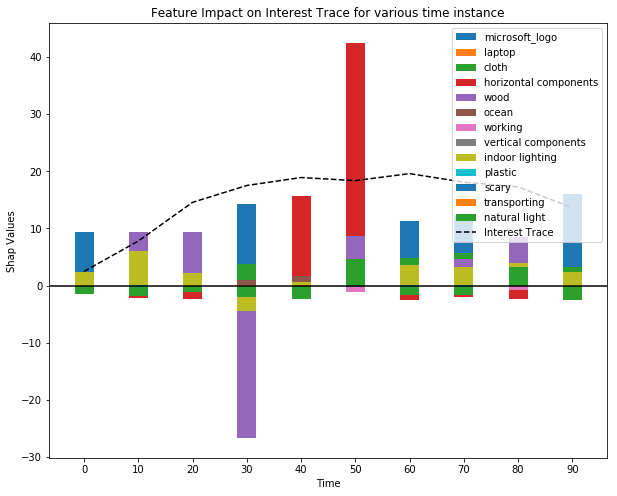

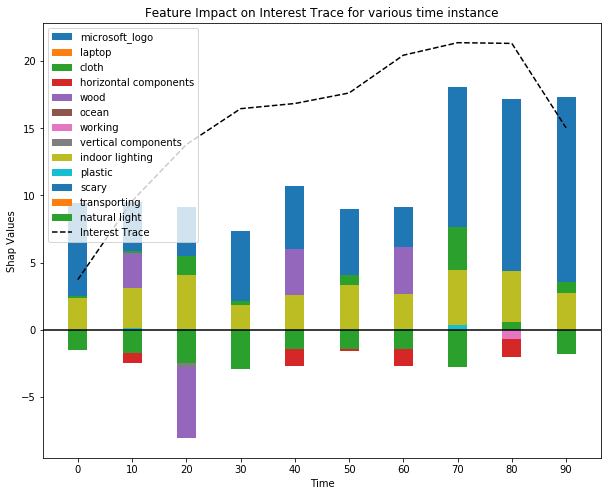

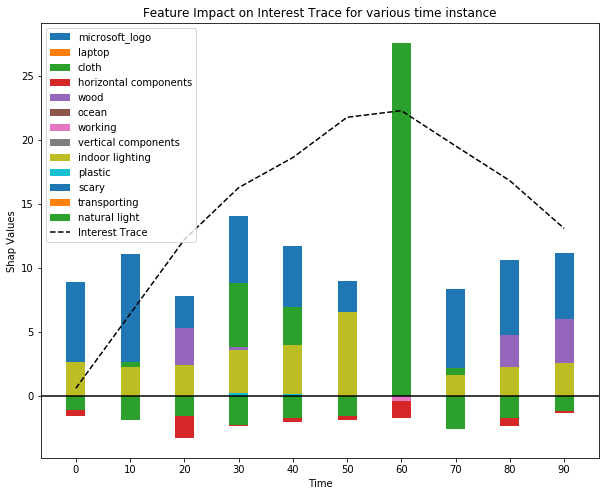

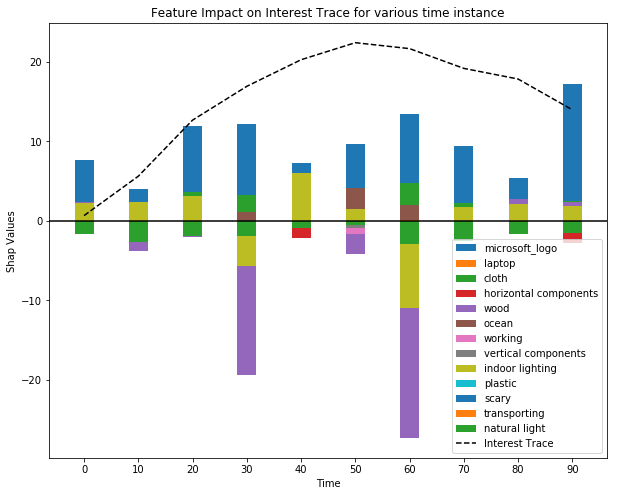

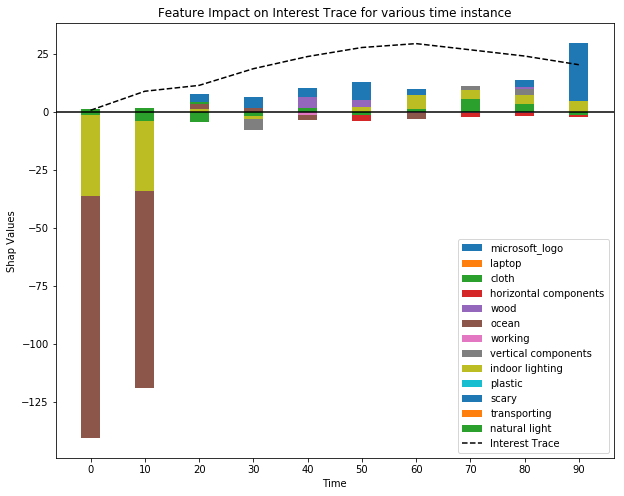

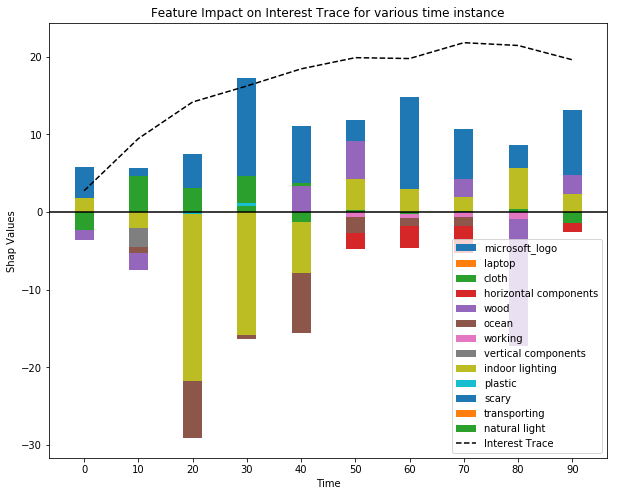

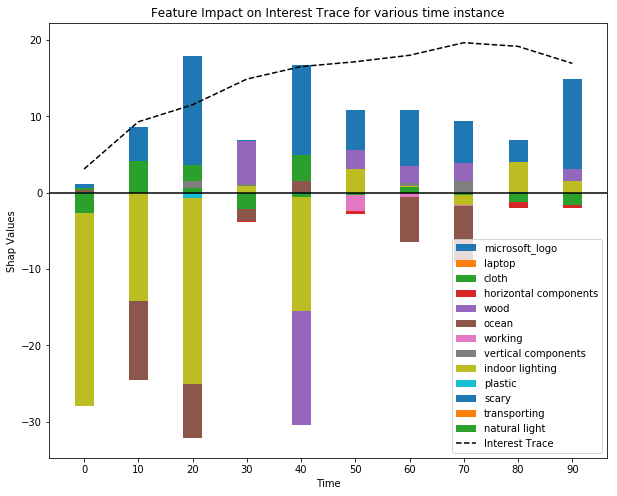

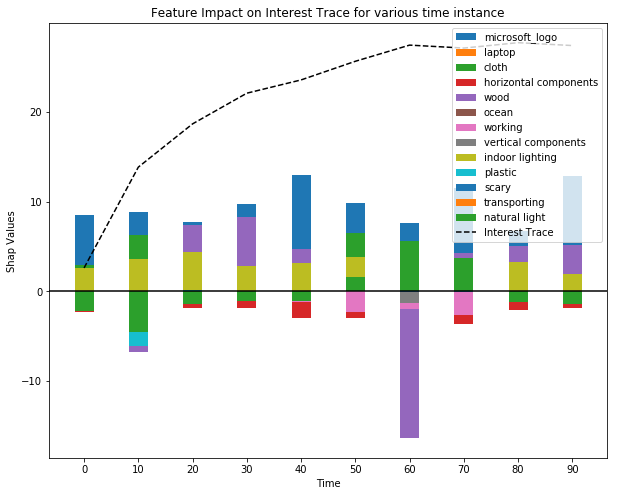

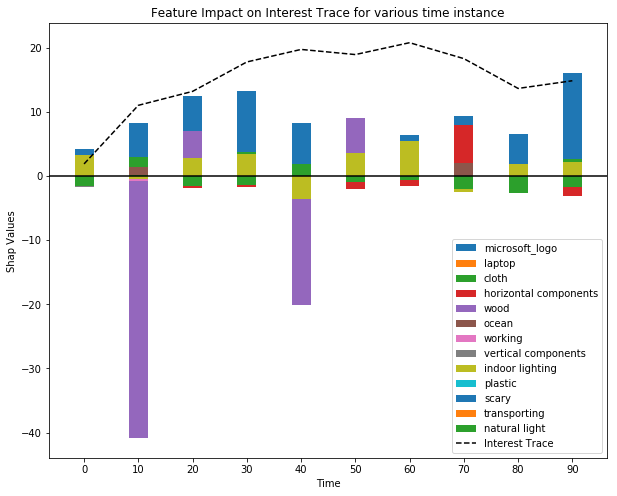

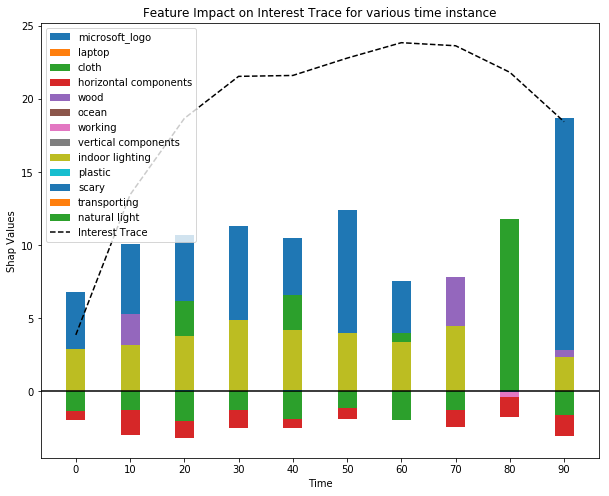

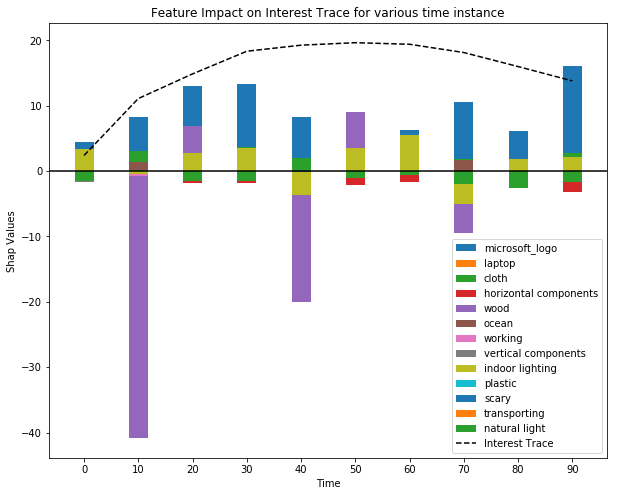

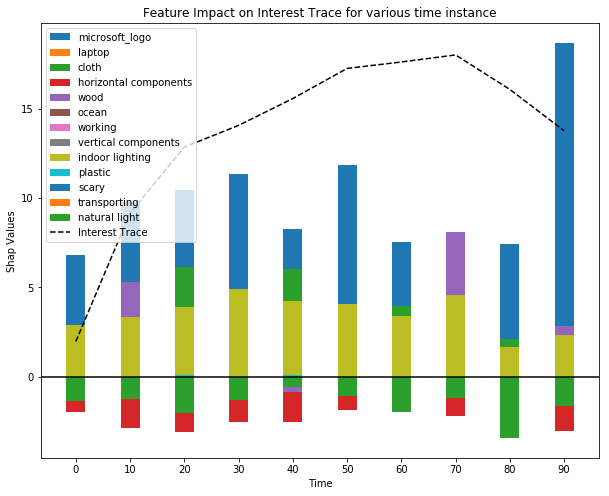

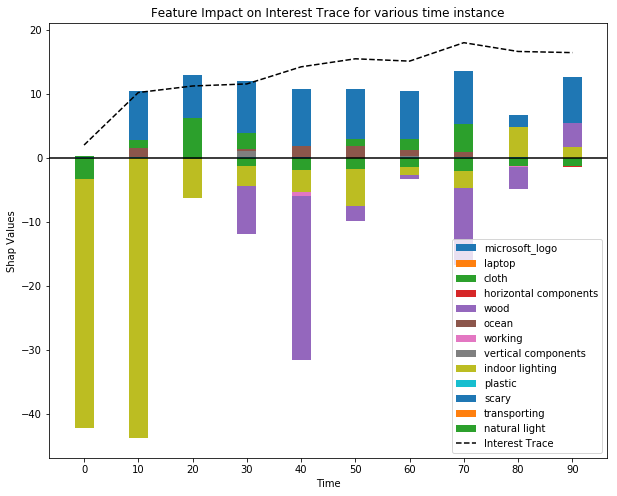

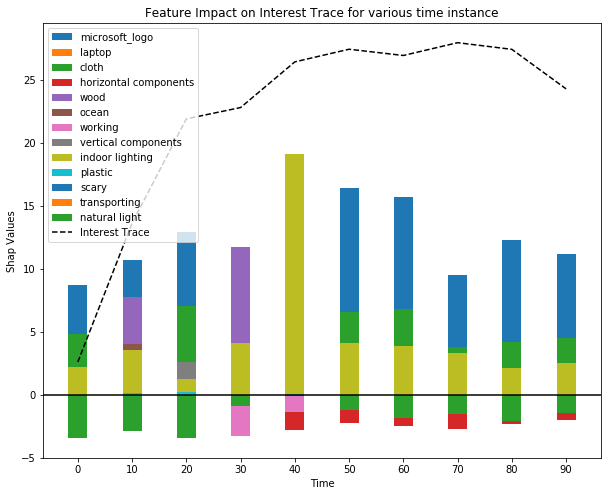

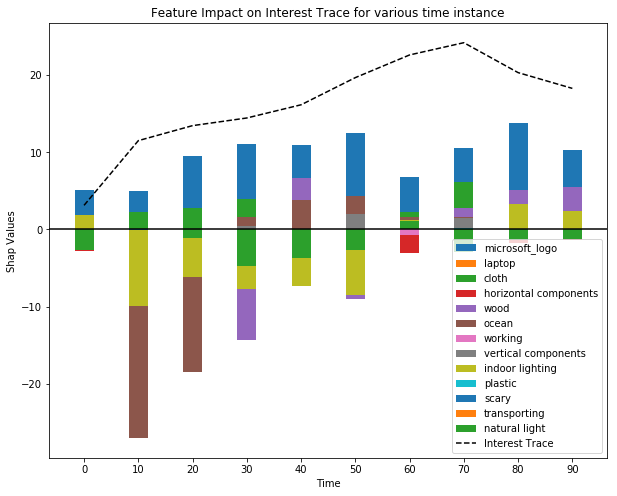

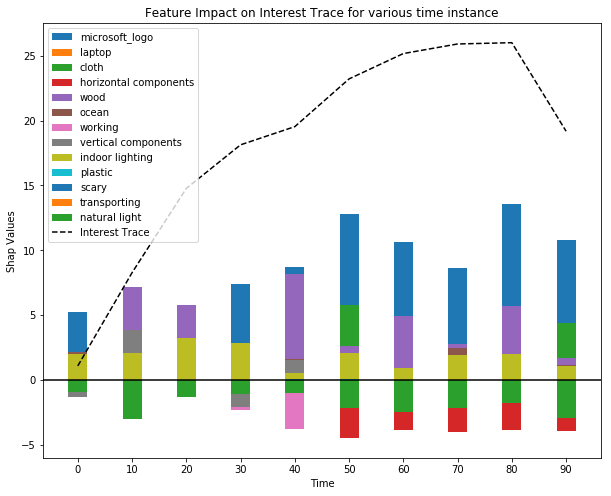

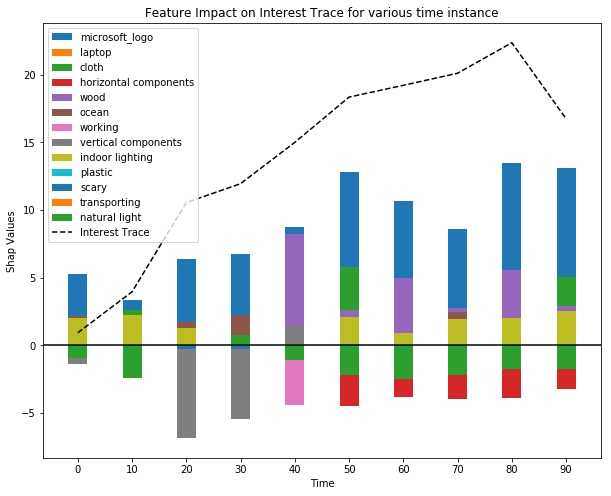

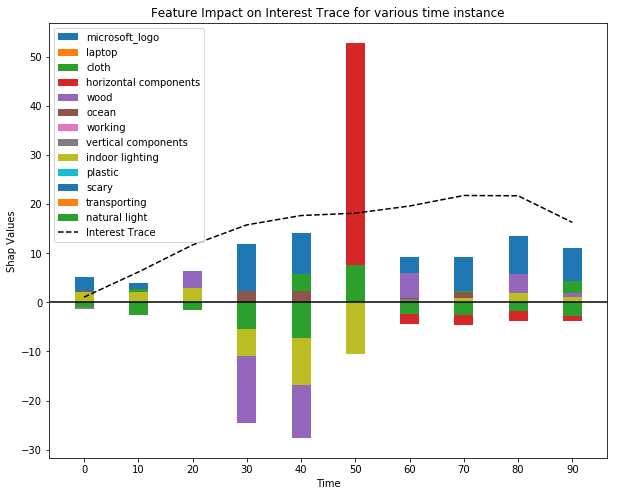

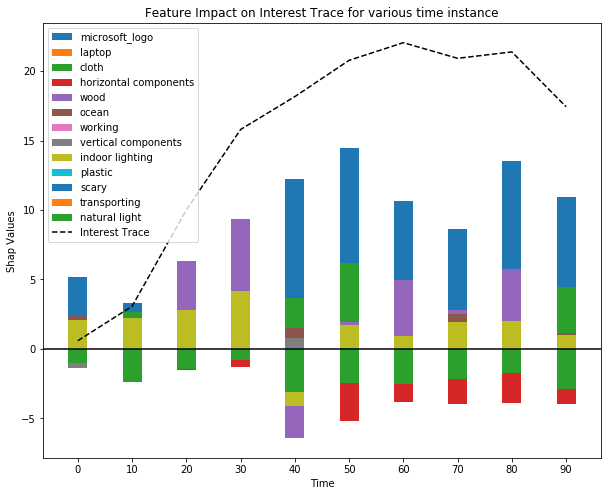

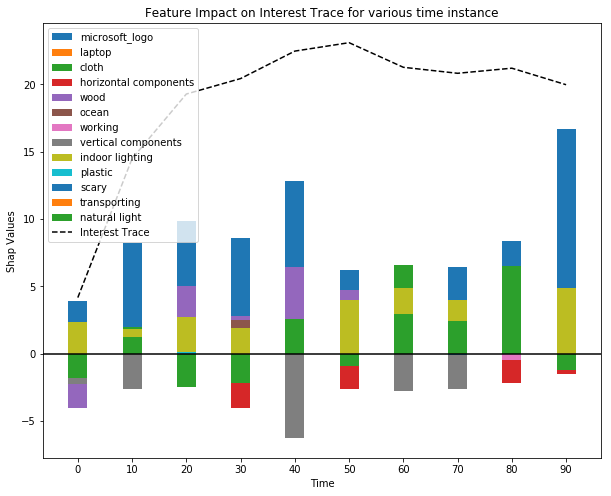

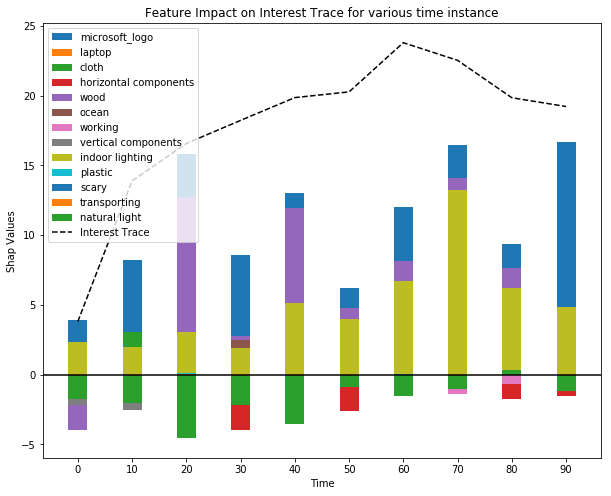

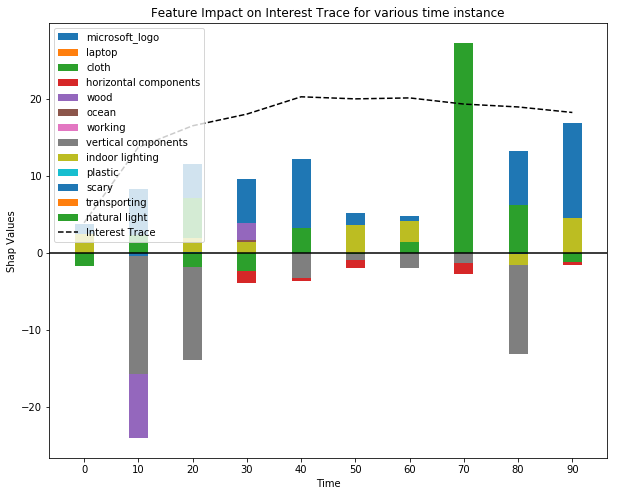

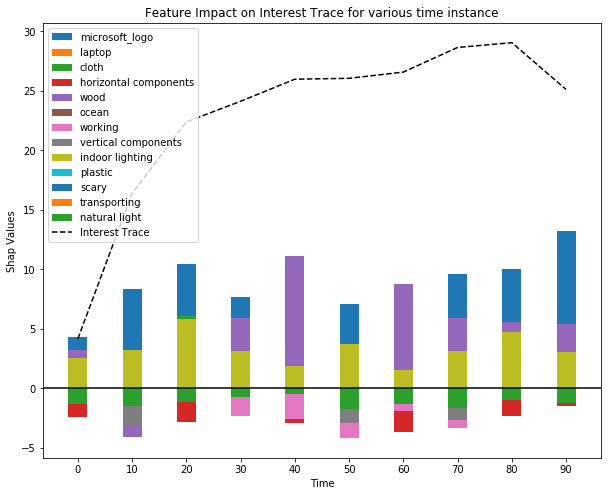

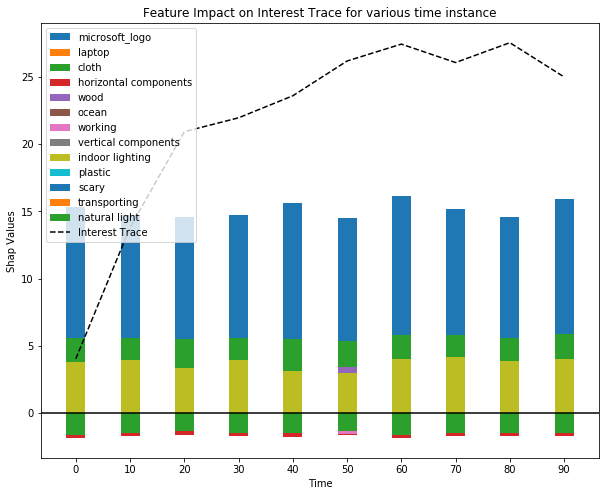

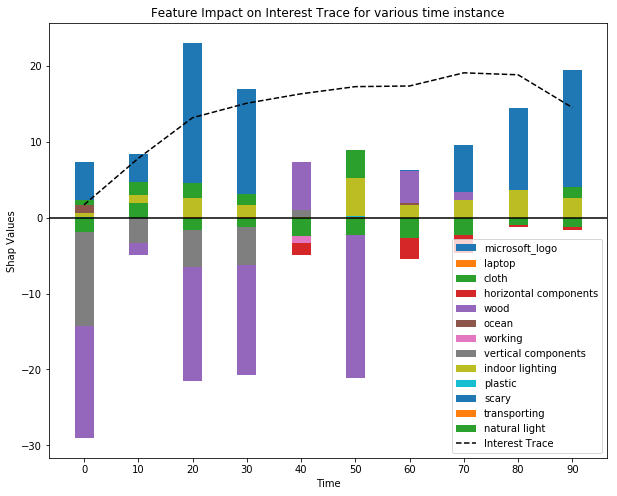

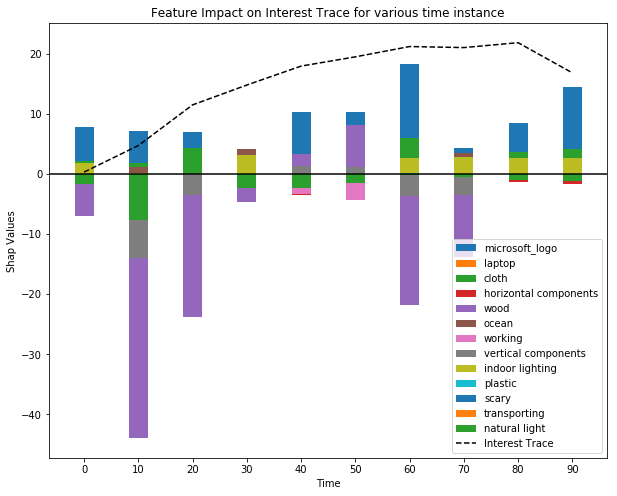

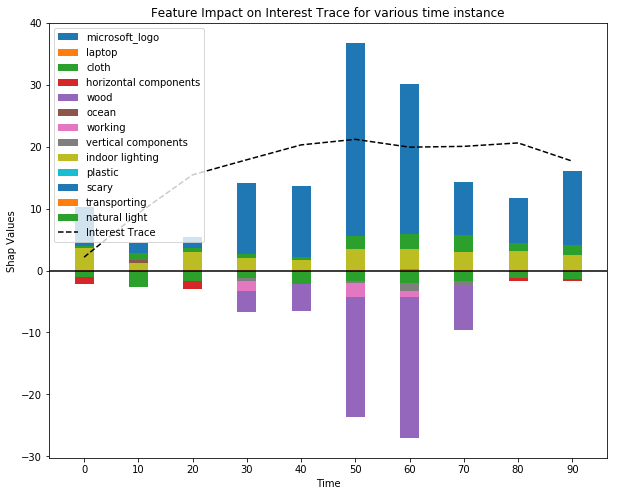

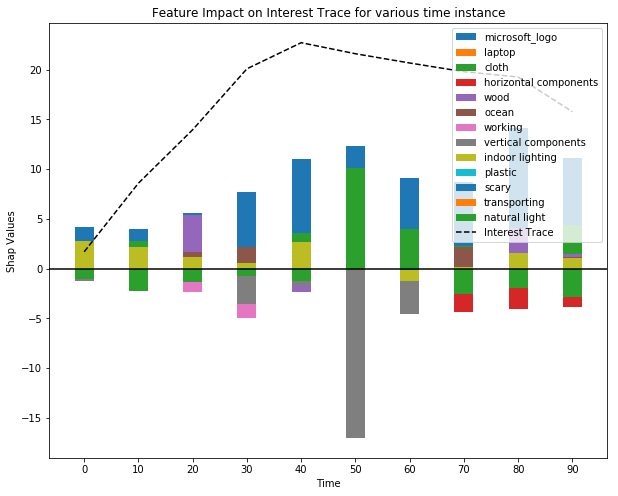

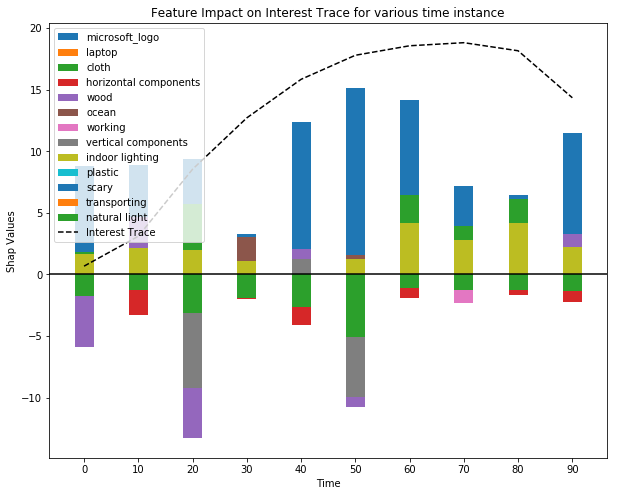

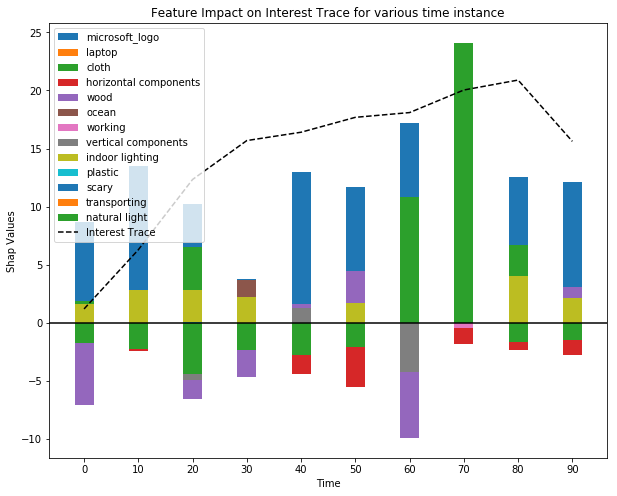

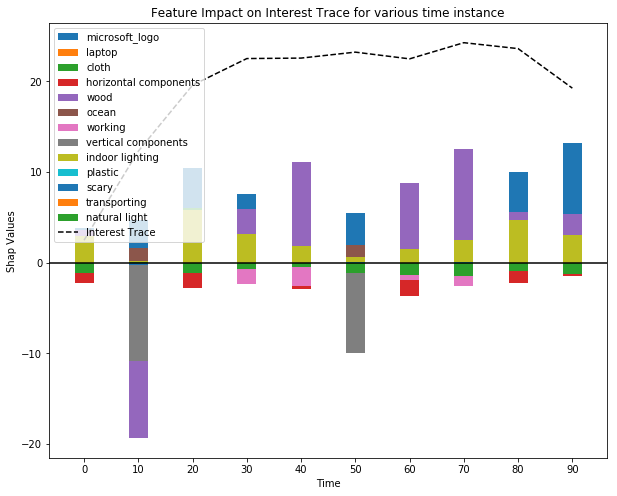

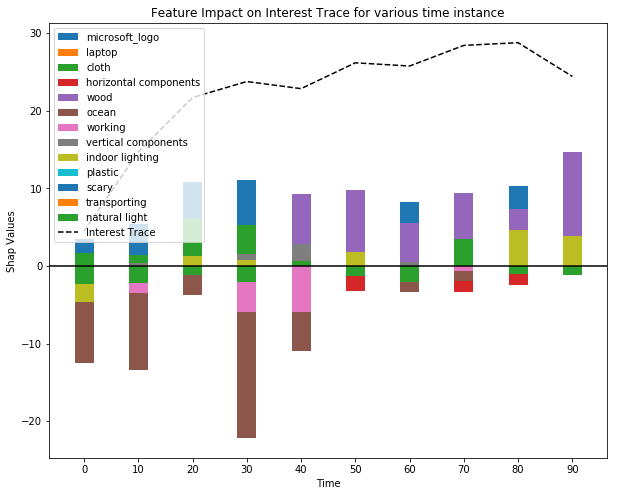

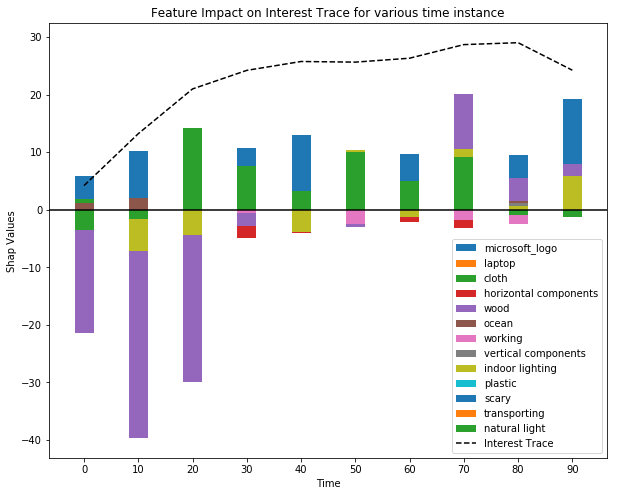

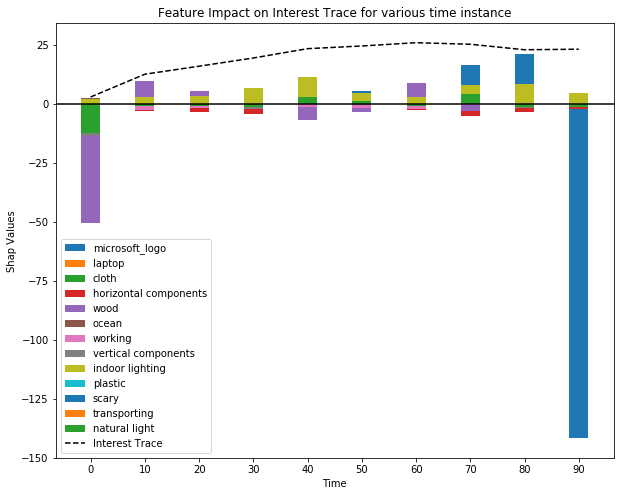

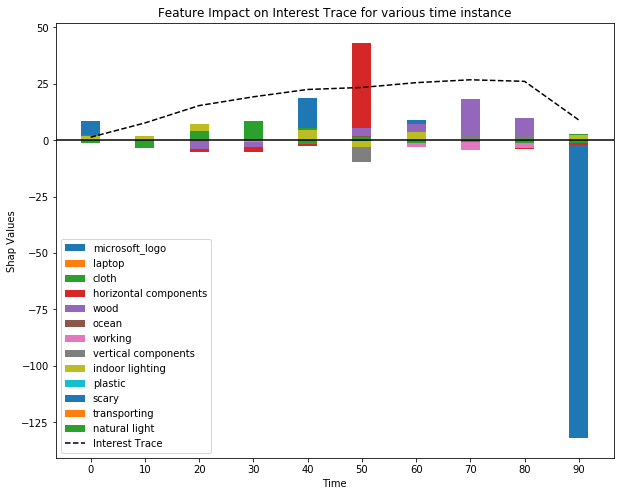

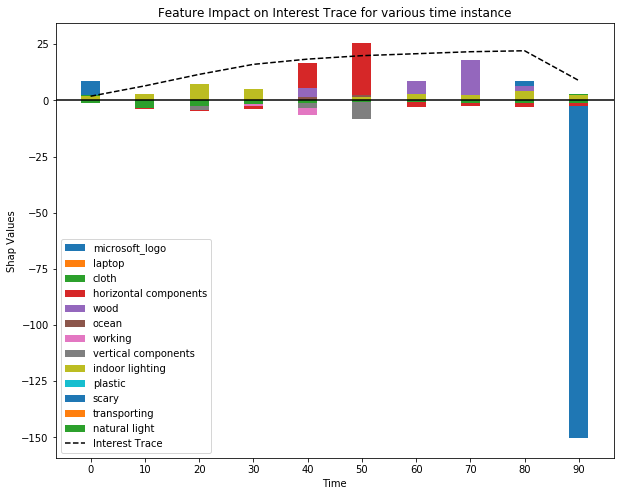

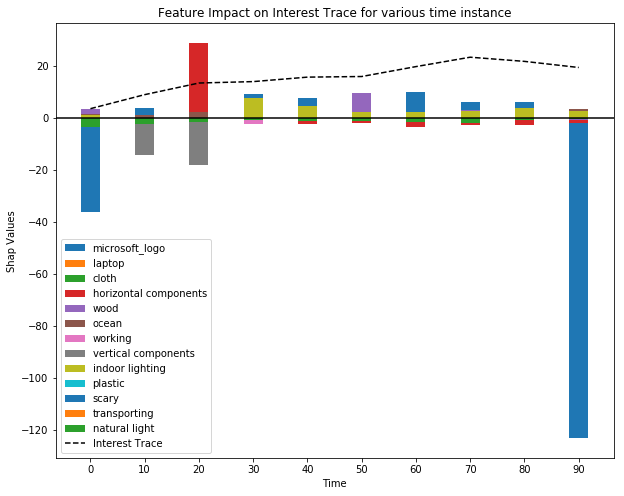

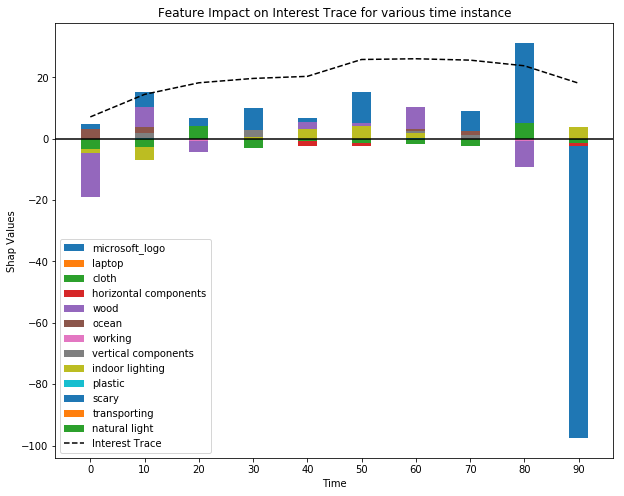

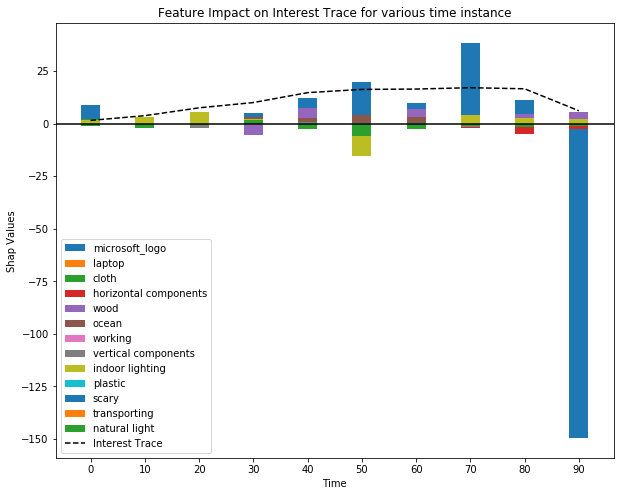

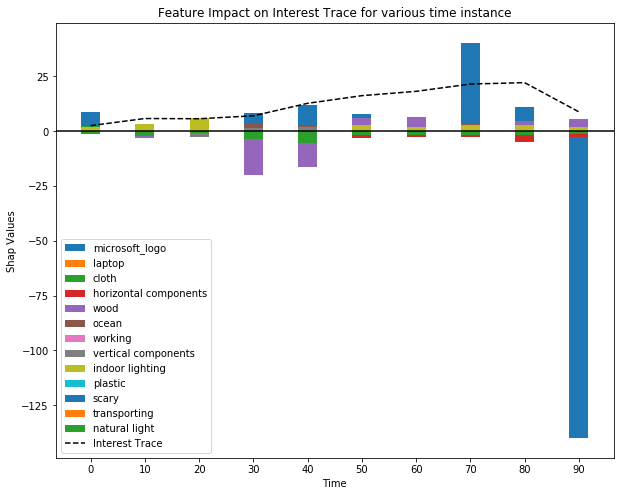

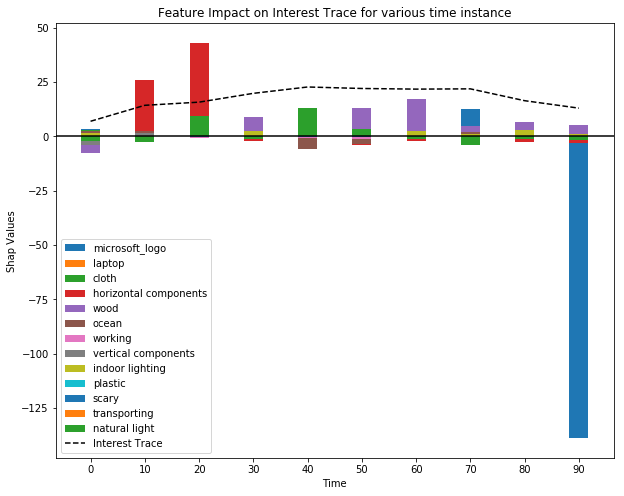

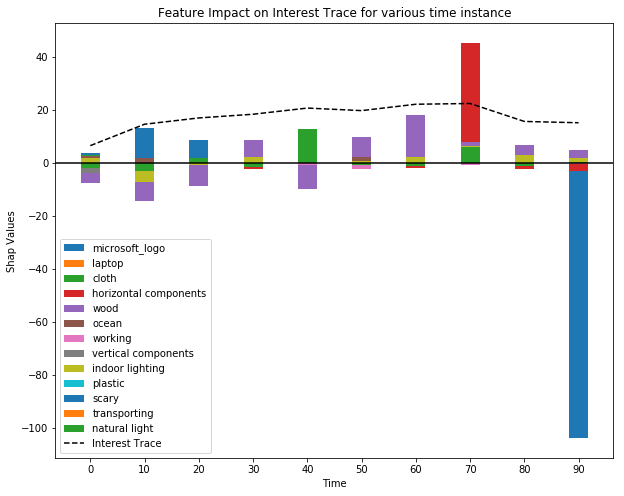

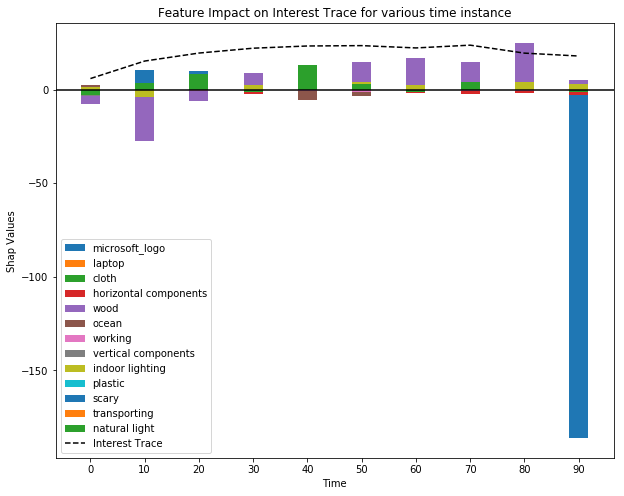

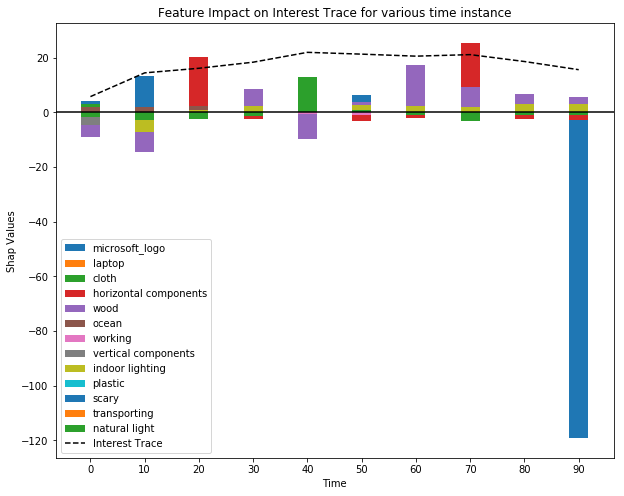

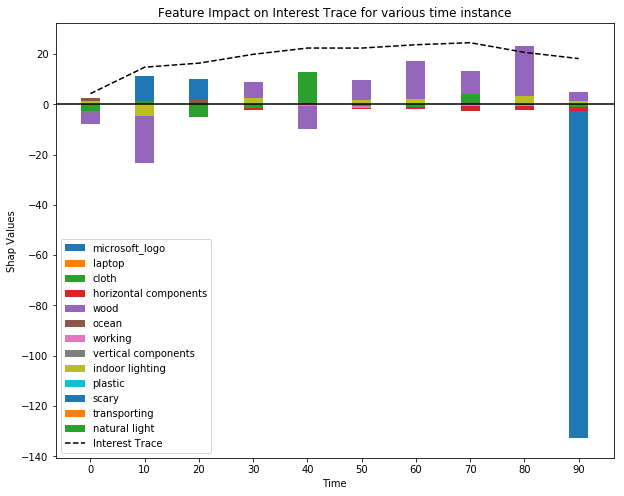

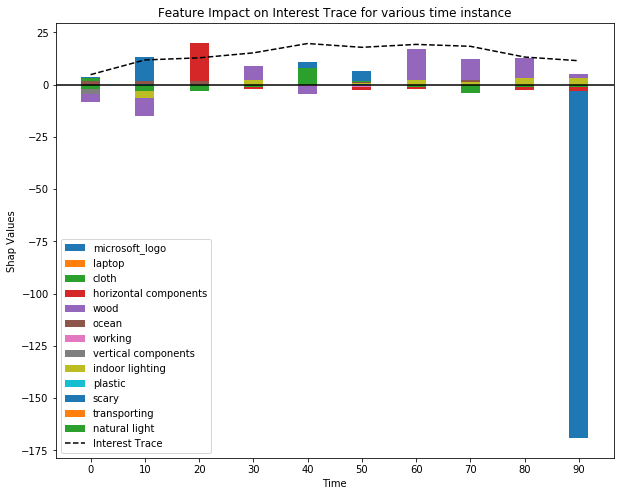

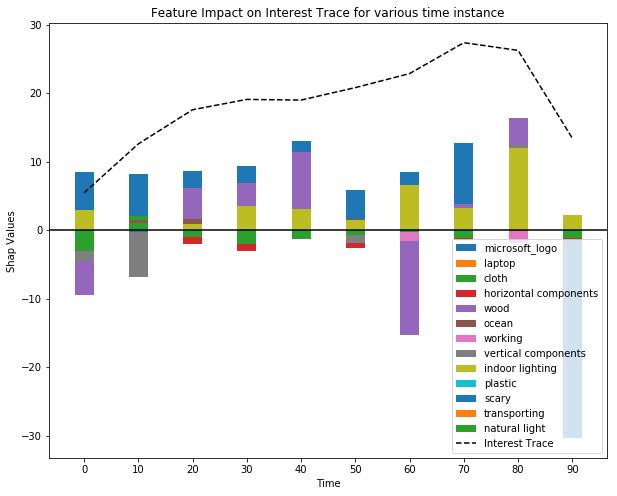

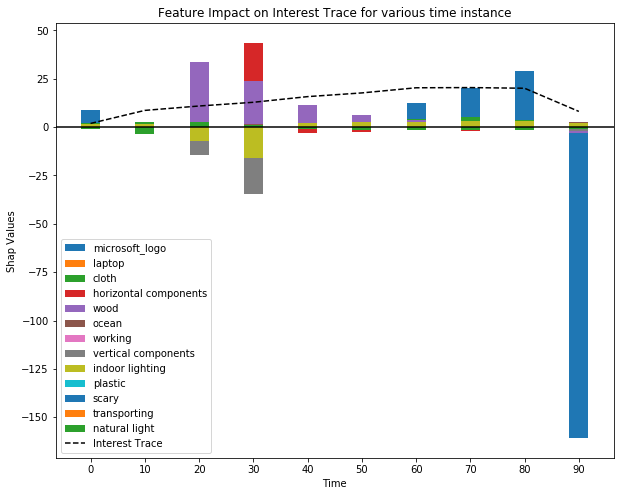

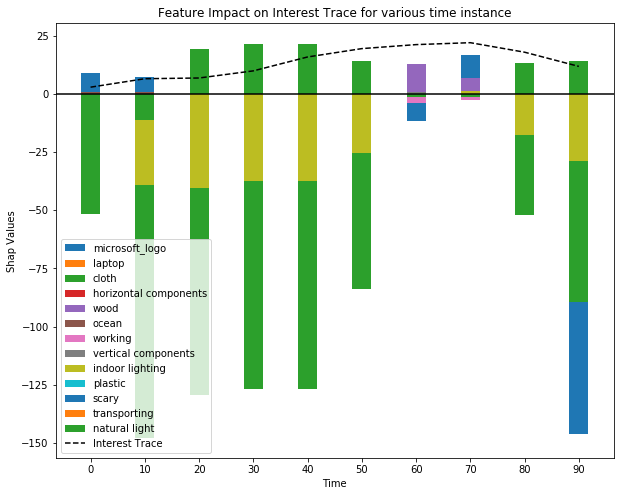

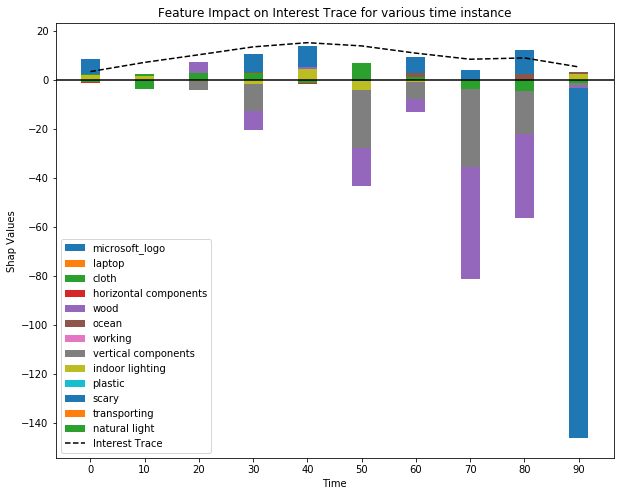

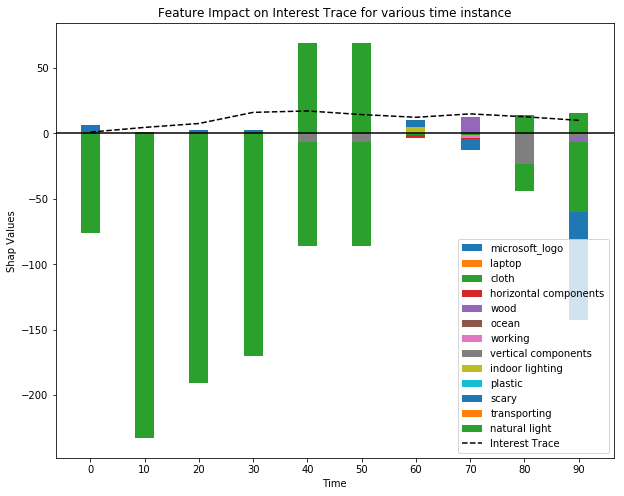

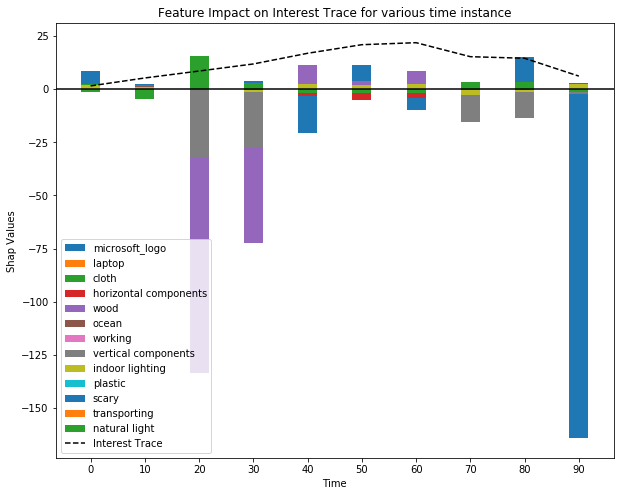

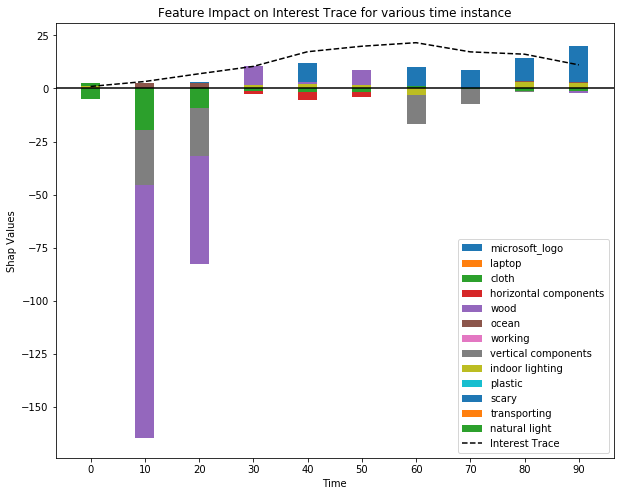

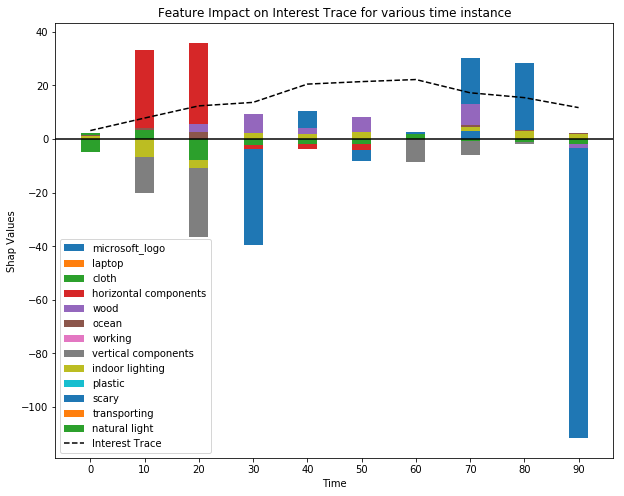

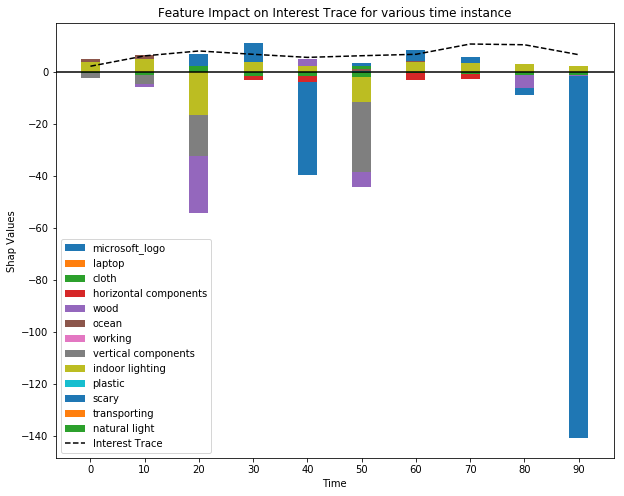

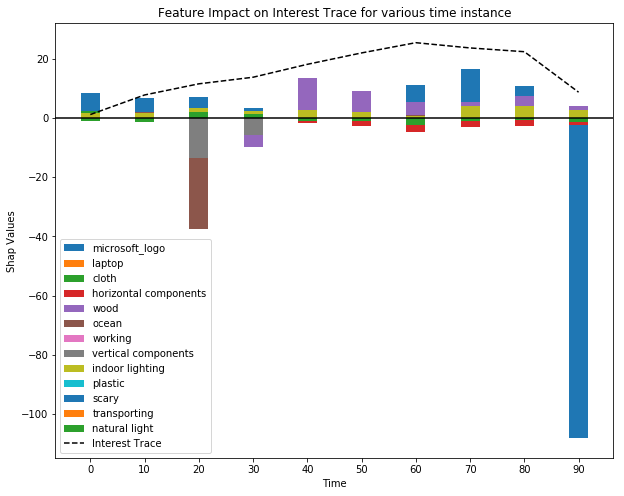

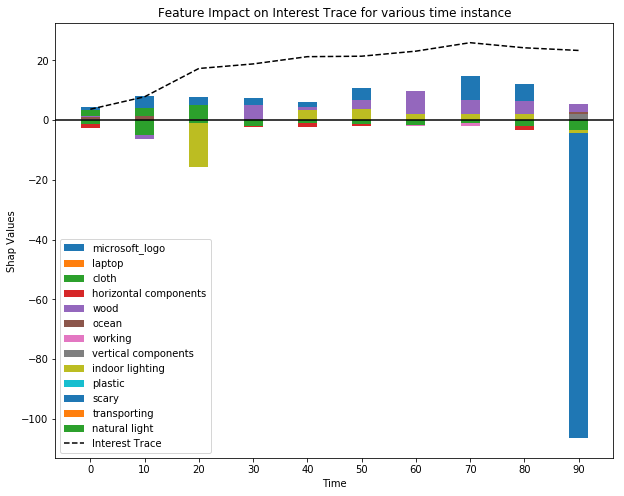

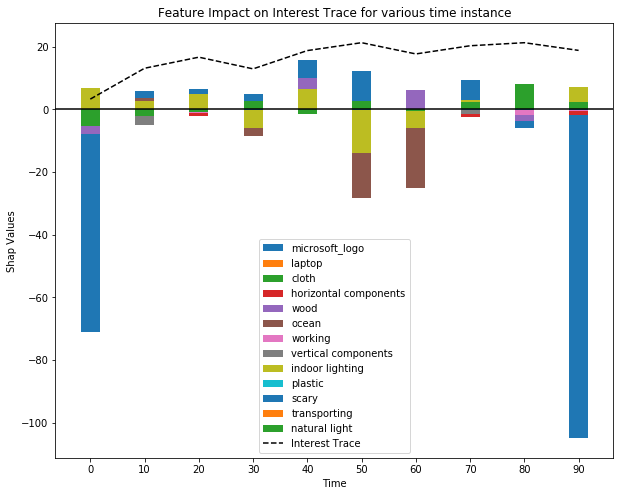

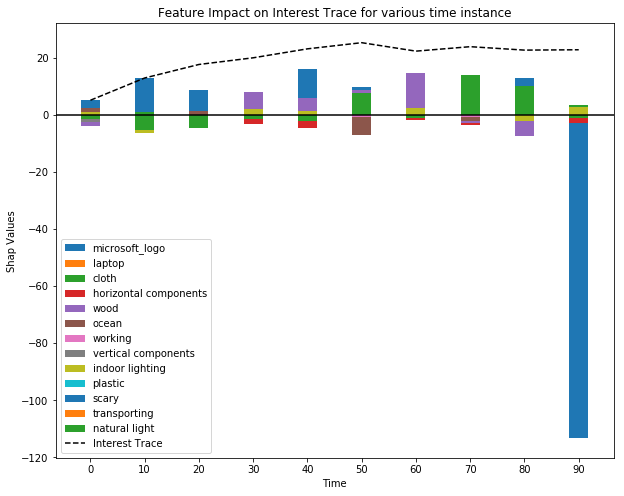

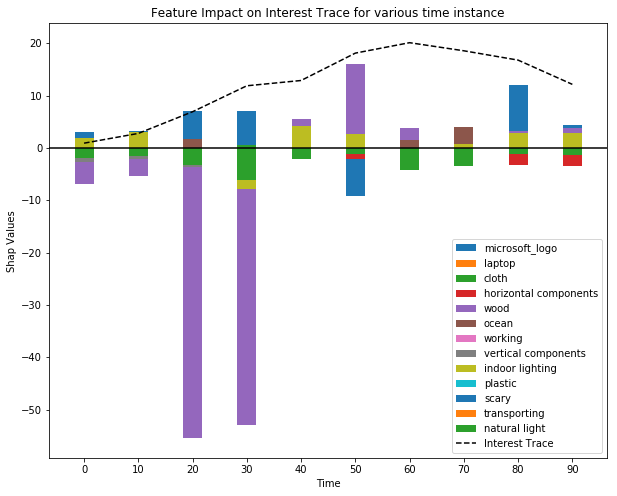

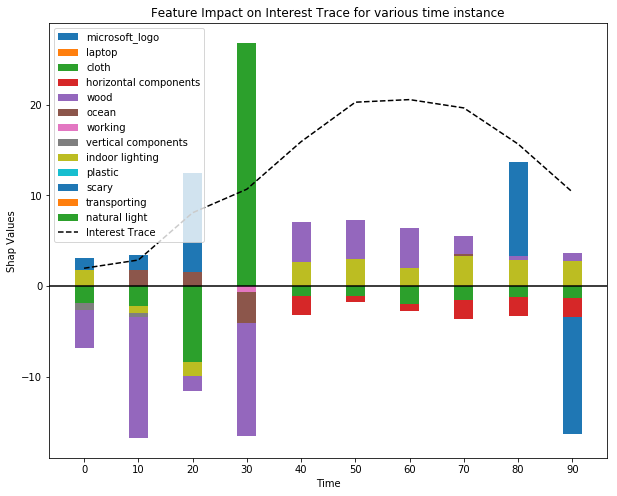

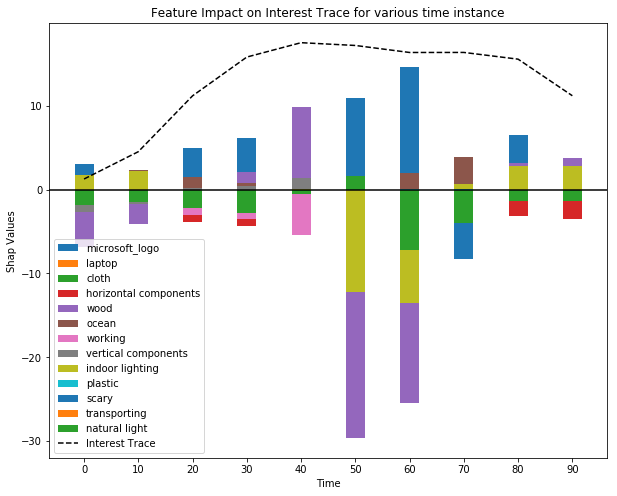

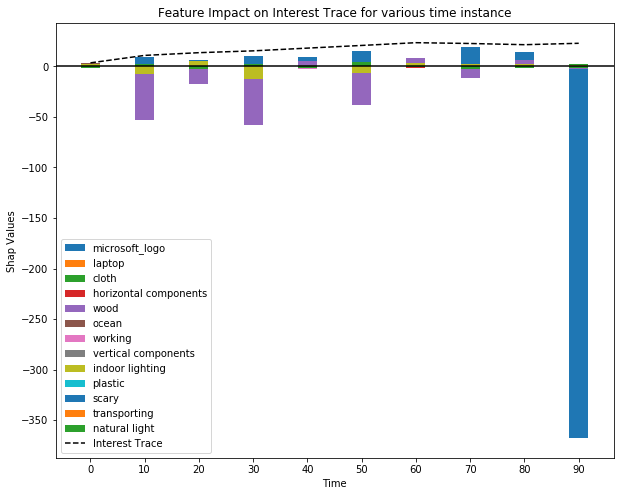

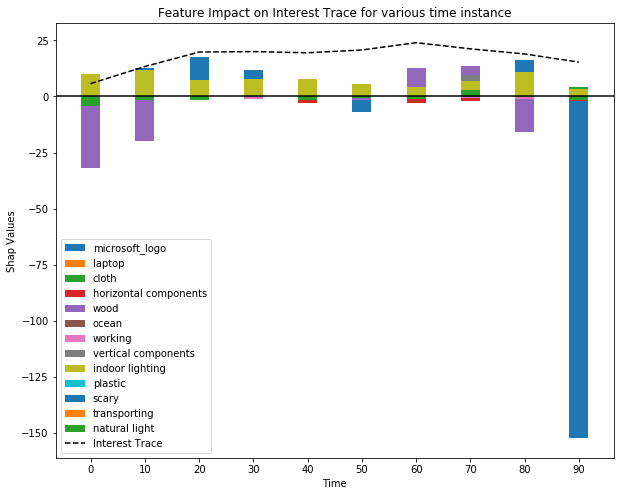

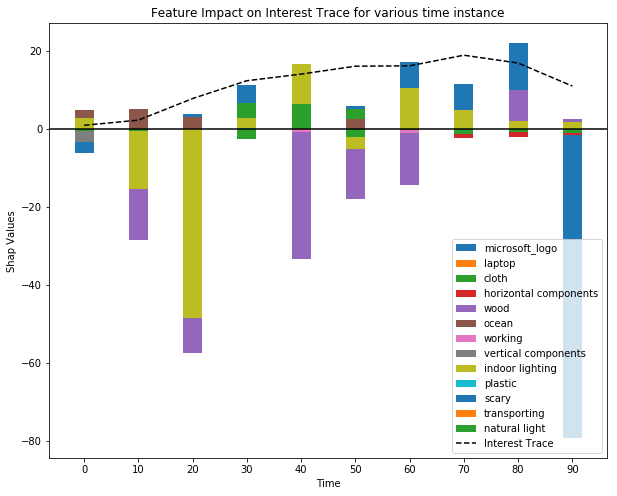

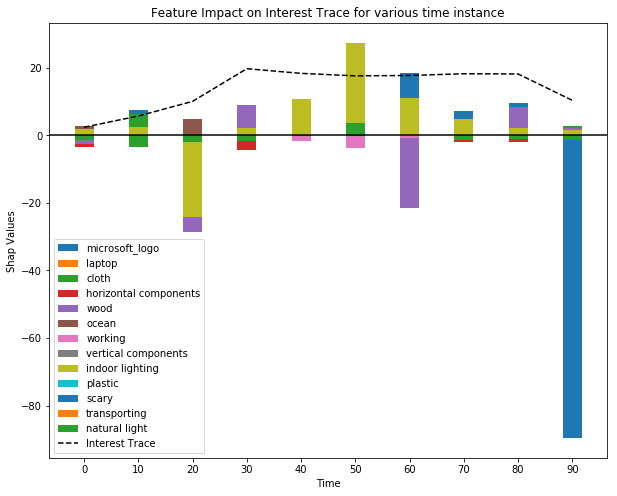

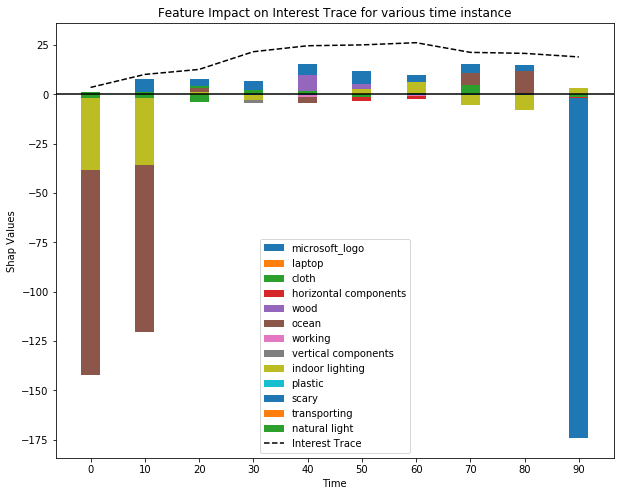

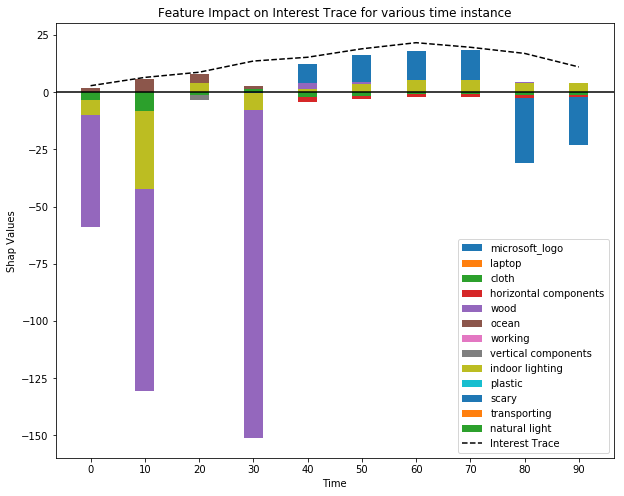

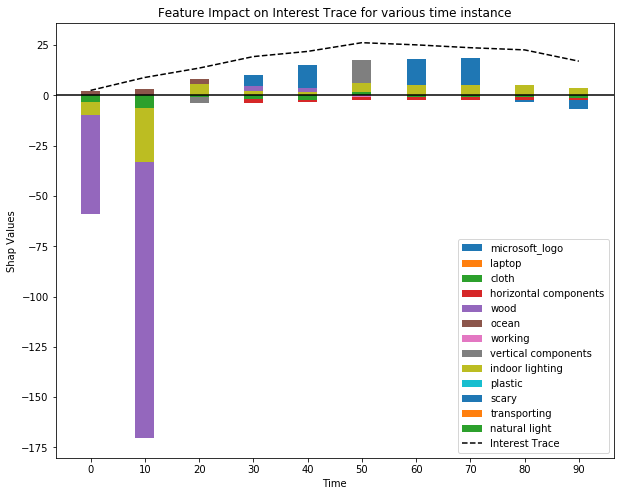

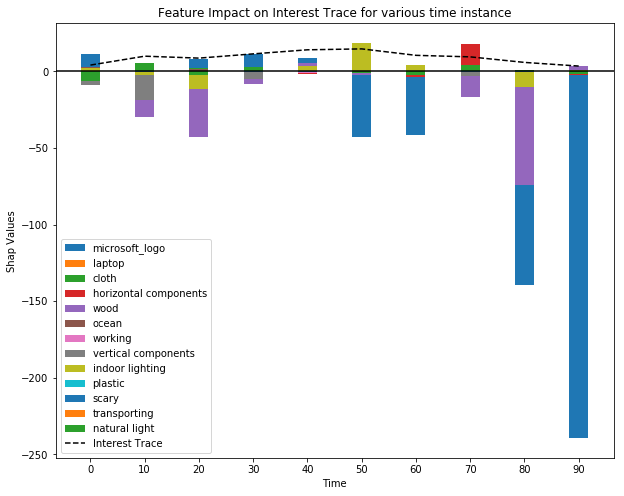

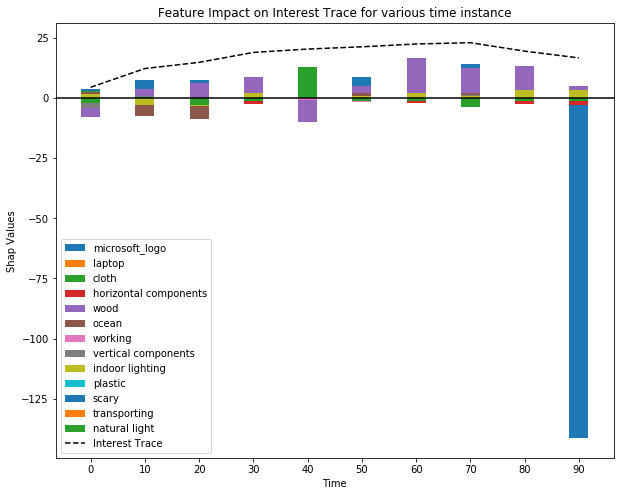

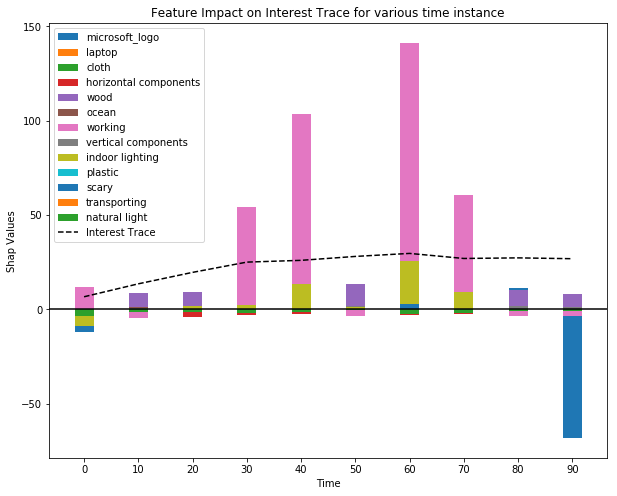

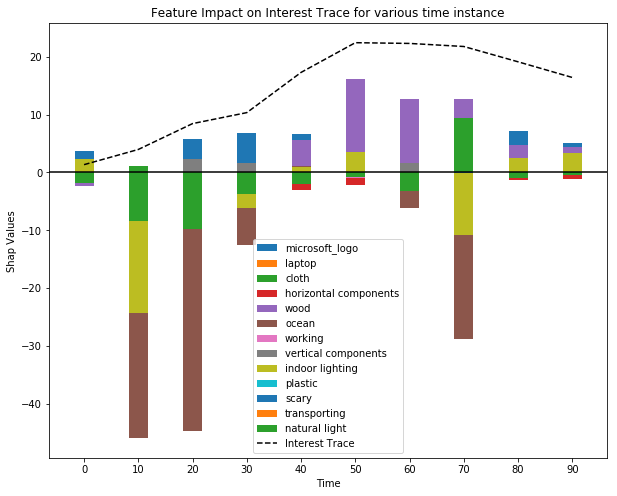

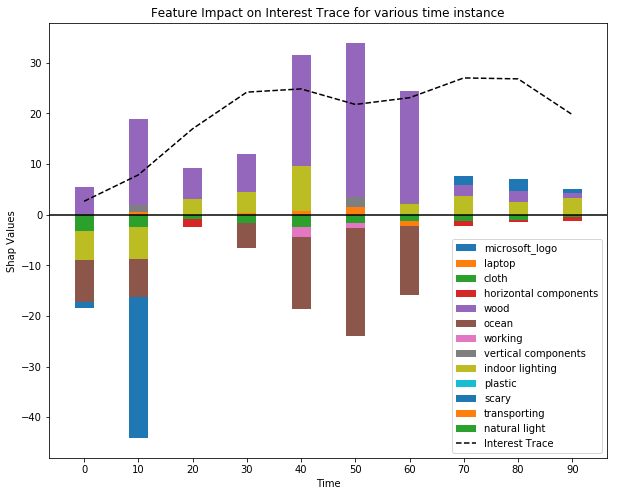

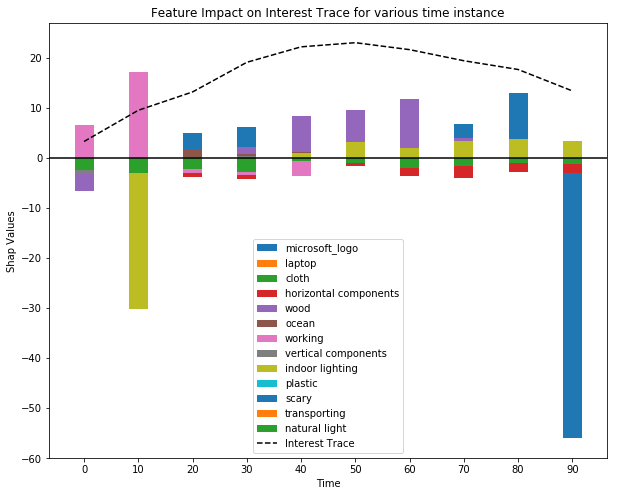

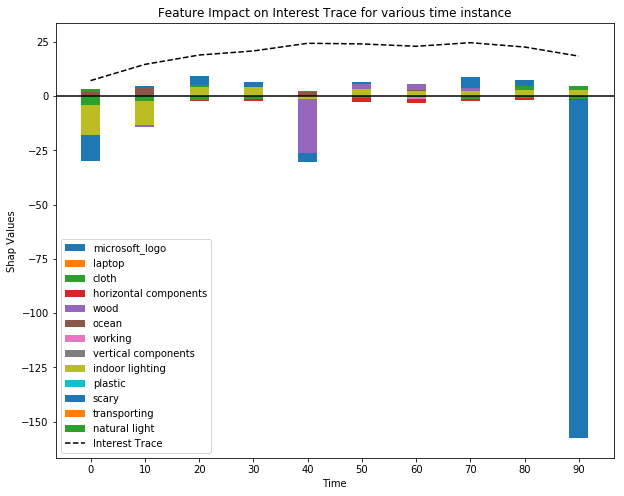

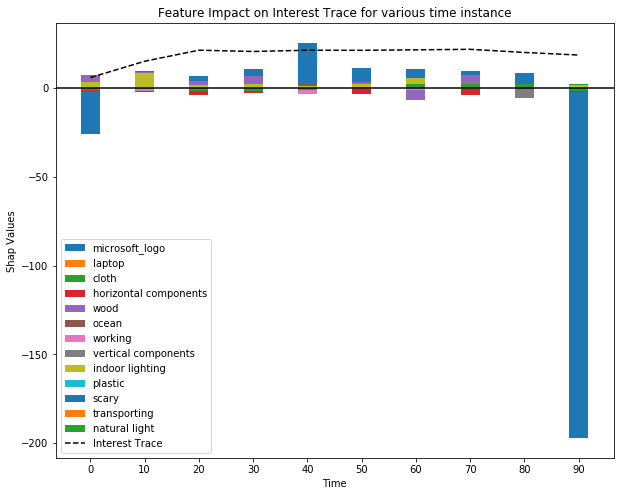

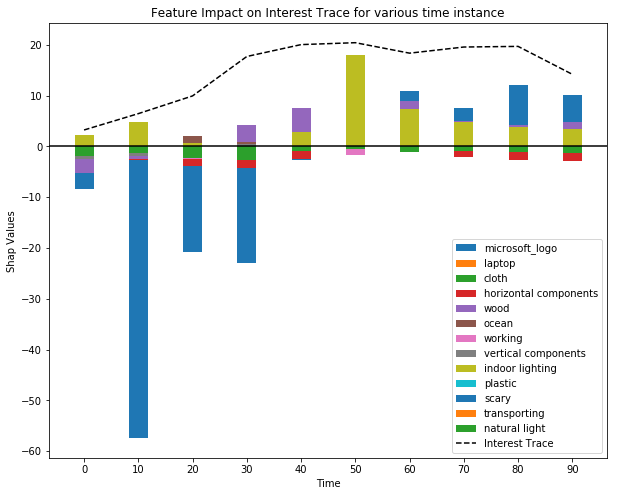

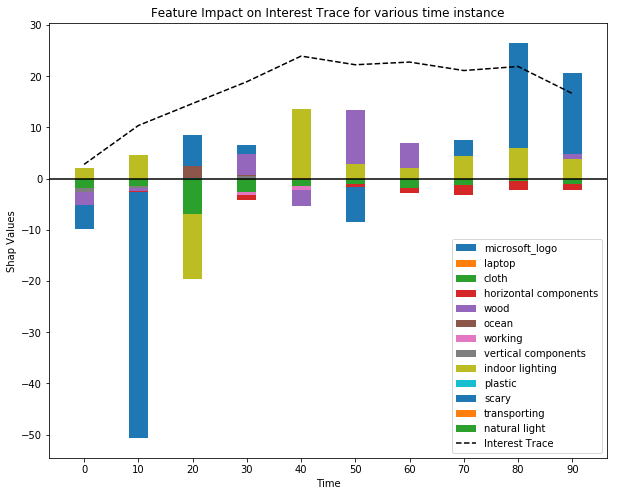

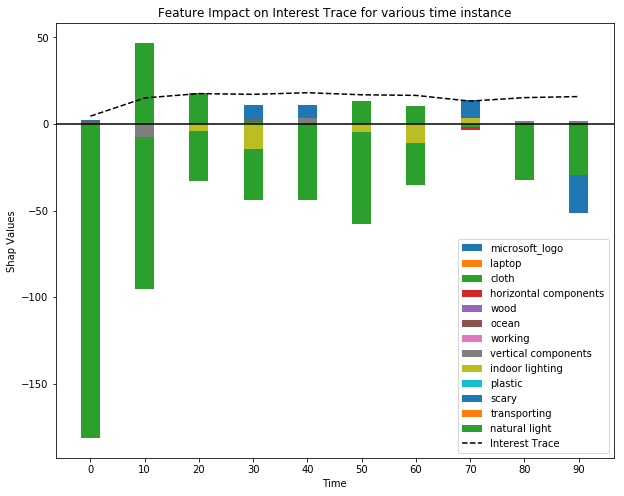

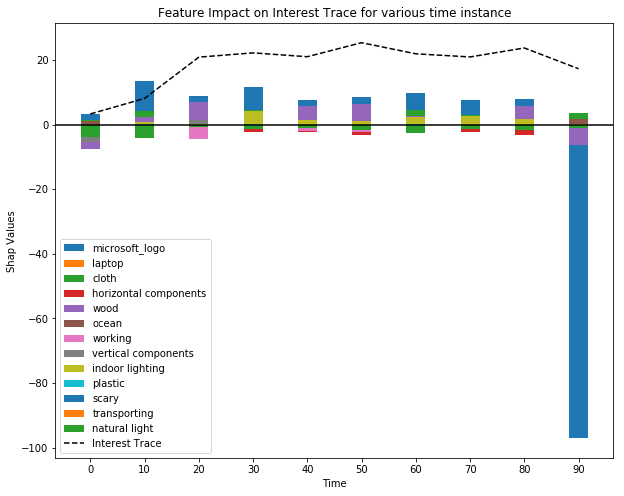

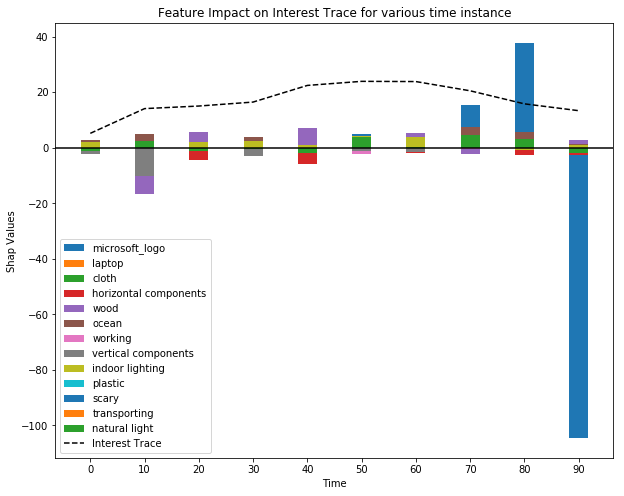

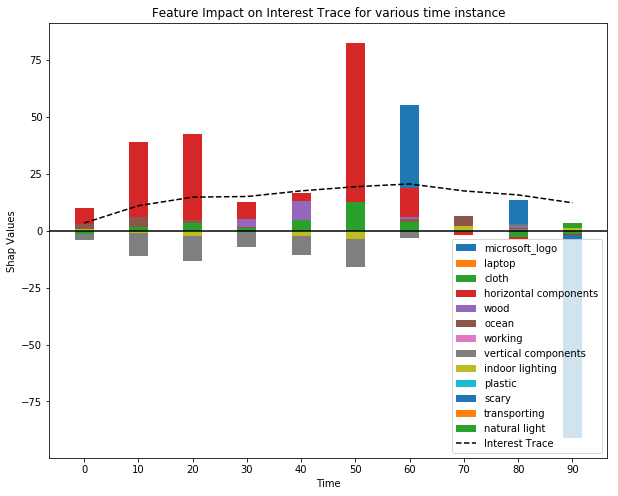

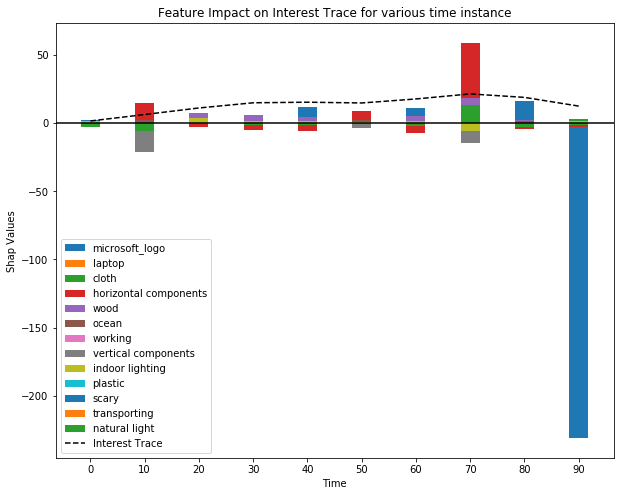

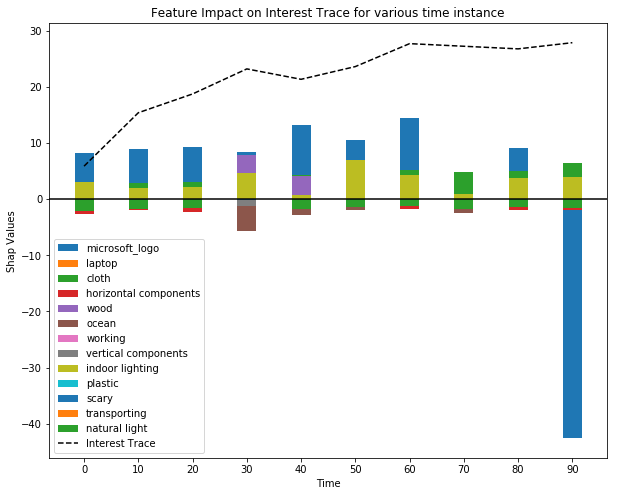

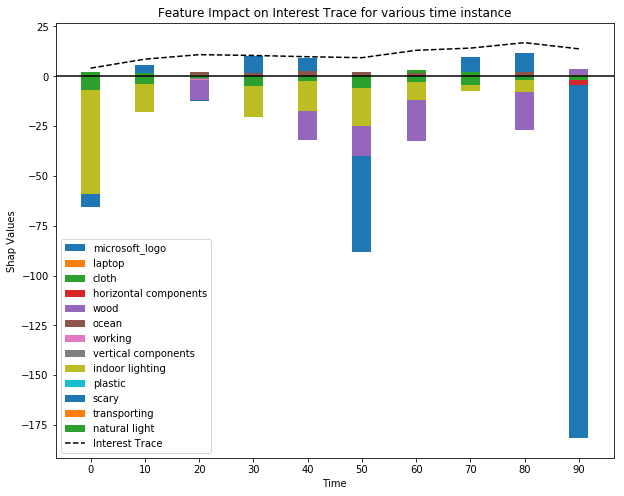

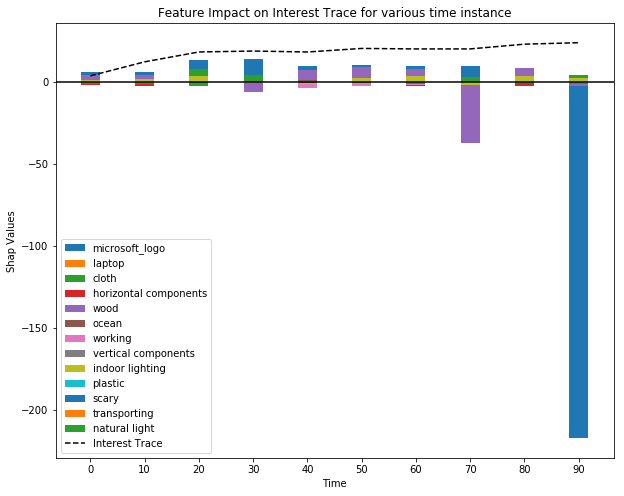

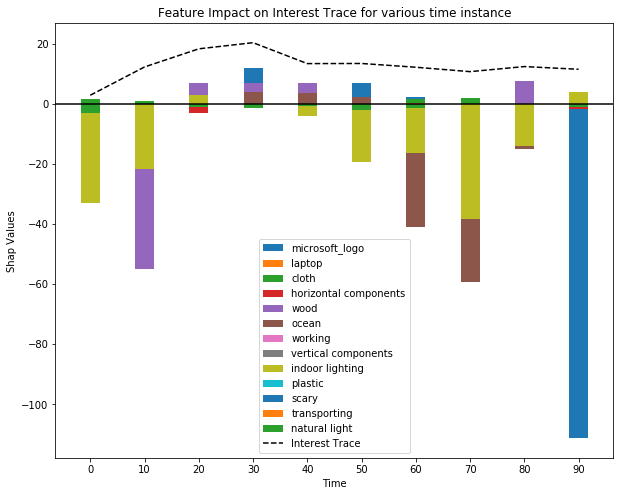

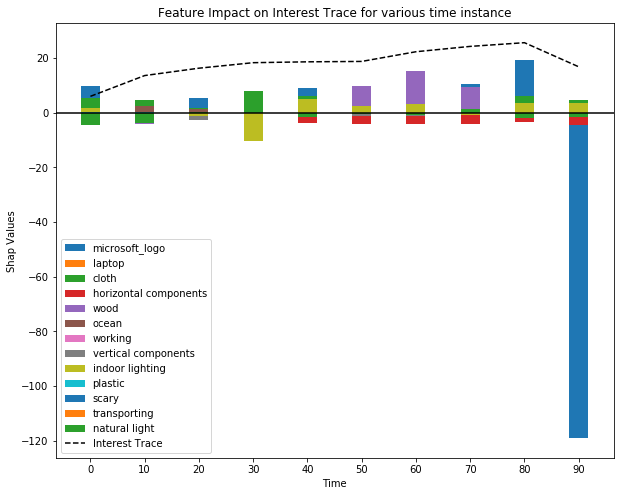

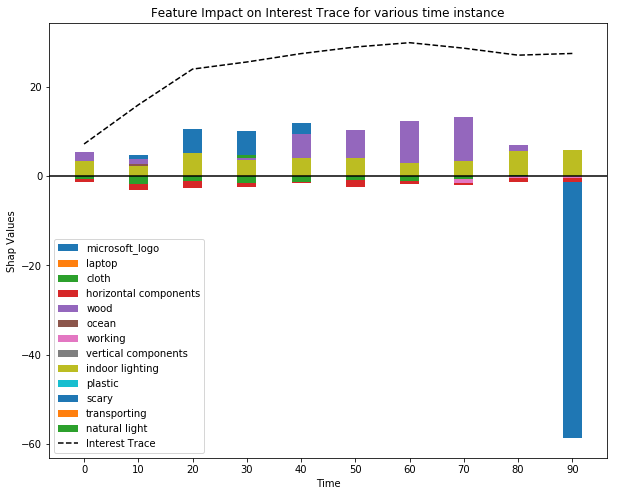

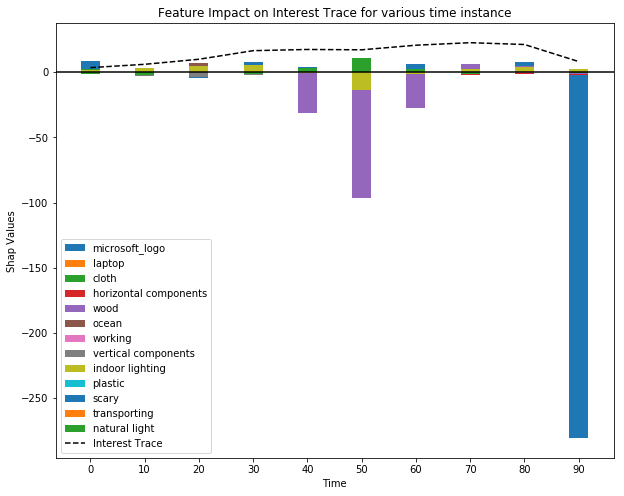

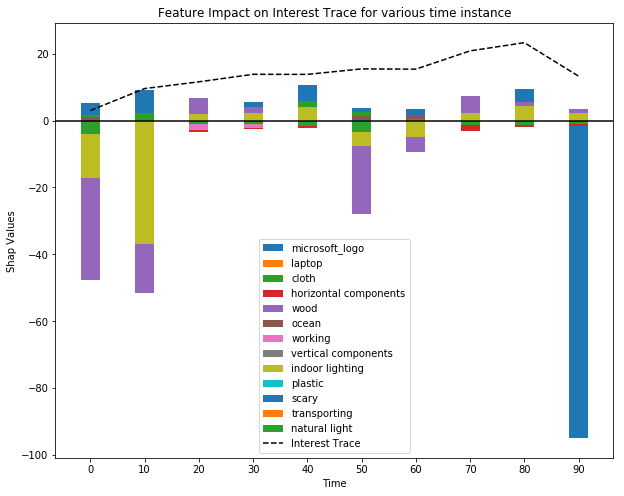

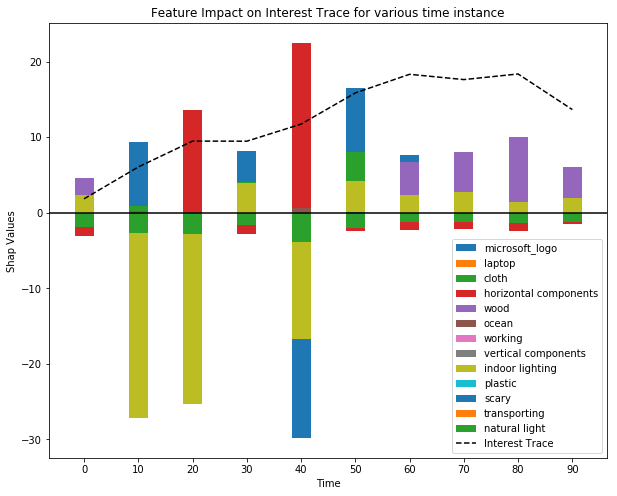

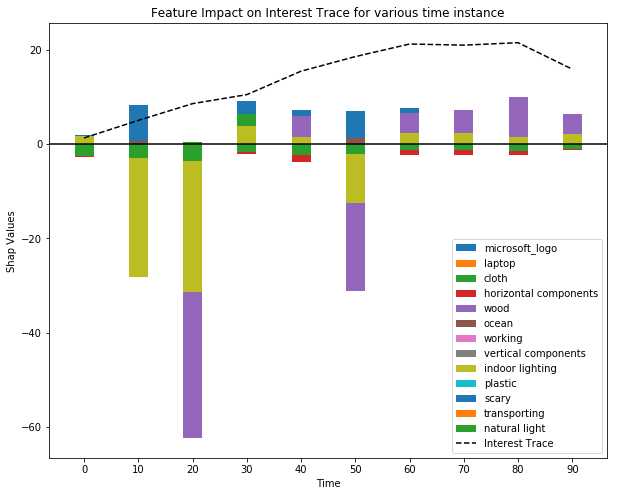

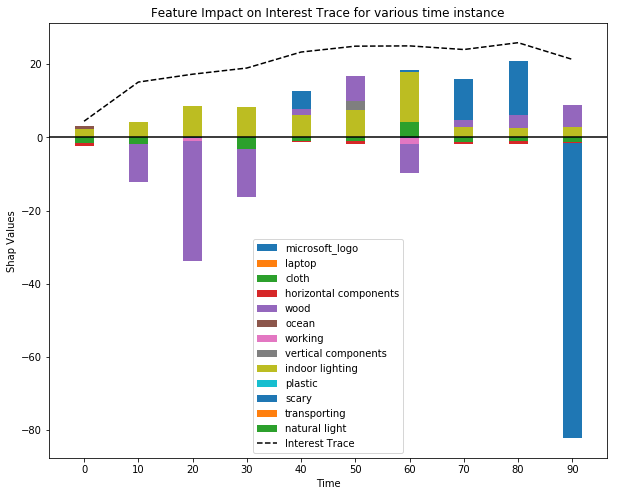

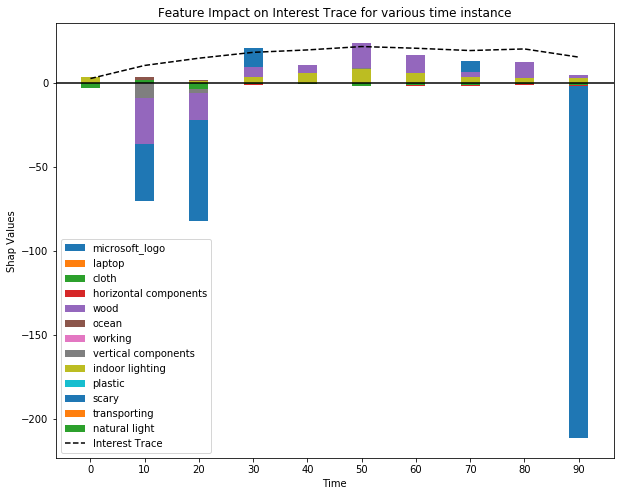

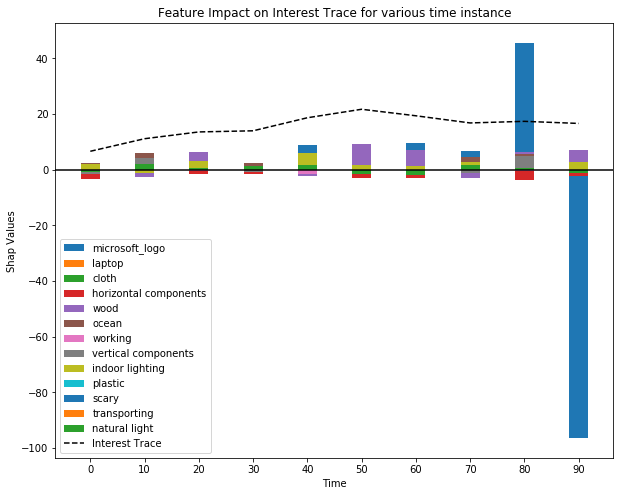

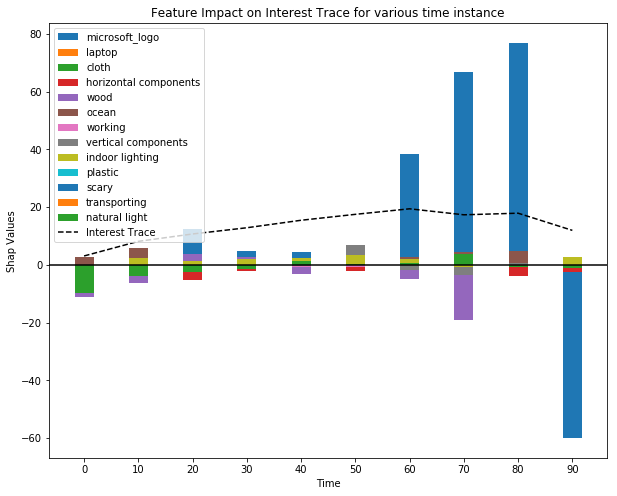

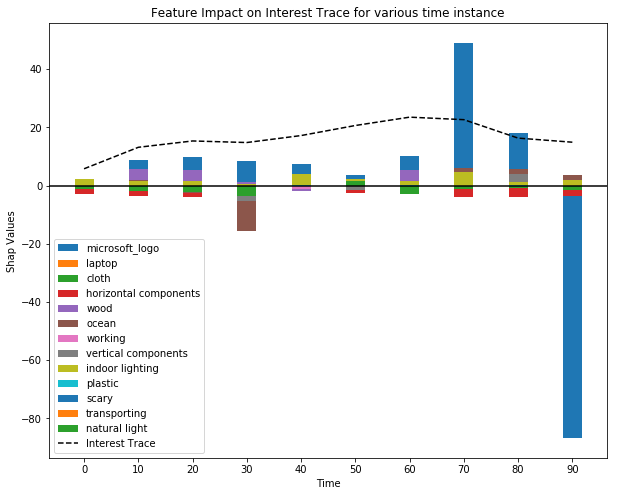

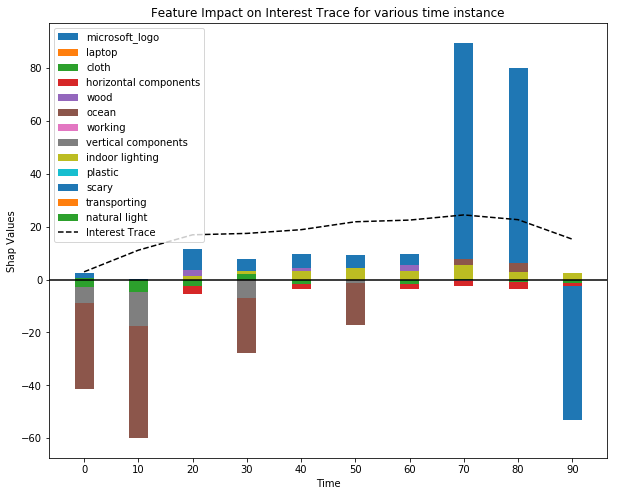

In [85]:
for l in tqdm(range(109)):
   
    shap_values_dt= explainer_dt.shap_values(videos[l].drop('Video Name',1))

    indices=[[],[],[],[],[],[],[],[],[],[]]
    for i in range(videos[l].shape[0]):
    #     print(X_train.iloc[i]['Ocr'])
        indices[videos[l].iloc[i]['Ocr']].append(i)

    time_wise_values = []
    for i in range(10):
        time_wise_values.append(shap_values_dt[indices[i]].mean(axis=0)*100)
    time_wise_values = np.array(time_wise_values)

    Y_trend = []
    y_plot = Y.loc[videos[l].index.values]
    for i in range(10):
        Y_trend.append(y_plot.iloc[indices[i]].mean())
    Y_trend = np.array(Y_trend)

    legend_arr = [col for col in videos[l].drop('Video Name',1).columns.values[index]]
    legend_arr.append("Interest Trace")

    plt.figure(figsize=(10,8))
    p=[]
    x_ticks = 10
    ind = np.arange(x_ticks)
    n_columns = len(legend_arr)-1
    for i in range(n_columns):
        p.append(plt.bar(ind,time_wise_values[:,i],width=0.35)[0])
    #     plt.bar(ind,shap_values_dt[:10,1],width=0.35)

    p.append(plt.plot(Y_trend,color="k",linestyle="--")[0])
    plt.xticks(ind,np.arange(100,step=10).astype('str'))
    plt.legend(p,legend_arr)
    # plt.ylim(-1,1)
    plt.axhline(y=0,color="k")
    plt.title("Feature Impact on Interest Trace for various time instance")
    plt.xlabel("Time")
    plt.ylabel("Shap Values")
    plt.savefig('./plot_interest_trace/videos_'+str(l)+'.png')
#     plt.show()

In [67]:
time_wise_values.shape

(10, 153)

## End

In [39]:
model_xgb = Model('xgb')
print("------------------------ XGB Model Training ----------------------------\n")
trained_xgb = model_xgb.train(X_train,y_train,X_test,y_test,metrics='r2',set_params=True,params={'Interest Trace':{'colsample_bytree': 0.4, 'max_depth': 15, 'min_samples_leaf': 4, 'n_estimators': 500,"objective":'reg:linear',"silent":False,"alpha":1,"learning_rate":0.01,"reg_lambda":1}},plot_error=False)

------------------------ XGB Model Training ----------------------------

Interest Trace


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   11.6s remaining:   17.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   15.3s finished


For training set
r2_score: 0.739560
For test set
r2_score: 0.743474




1. frame_0_25 (0.662528)
2. frame_50_75 (0.036703)
3. ocean (0.028585)
4. transporting (0.021941)
5. frame_75_100 (0.019247)
6. scary (0.018830)
7. length_of_ad_30 (0.015636)
8. frame_25_50 (0.007360)
9. far-away horizon (0.005085)
10. dell xps (0.004458)
11. surface pro 6 (0.004388)
12. sand (0.003475)
13. hp spectre x360, windows (0.003295)
14. tiles (0.003253)
15. vinyl (0.003100)
16. enclosed area (0.003063)
17. brick (0.002650)
18. cloth (0.002523)
19. horizontal components (0.002464)
20. hp (0.002424)
21. surface pen (0.002423)
22. driving (0.002312)
23. natural (0.002284)
24. working (0.002171)
25. waiting in line (0.002170)
26. age: 45-60 (0.002082)
27. windows 10 pcs (0.002081)
28. cold (0.002047)
29. matte (0.002045)
30. asphalt (0.002037)
31. boating (0.001983)
32. ad_type_tv (0.001937)
33. tablet (0.001908)
34. praying (0.001889)
35. plastic (0.001879)
36. vertical components (0.001876)
37. sunny (0.001865)
38. surface pro 4, hp spectre x360 (0.001847)
39. shopping (0.00181

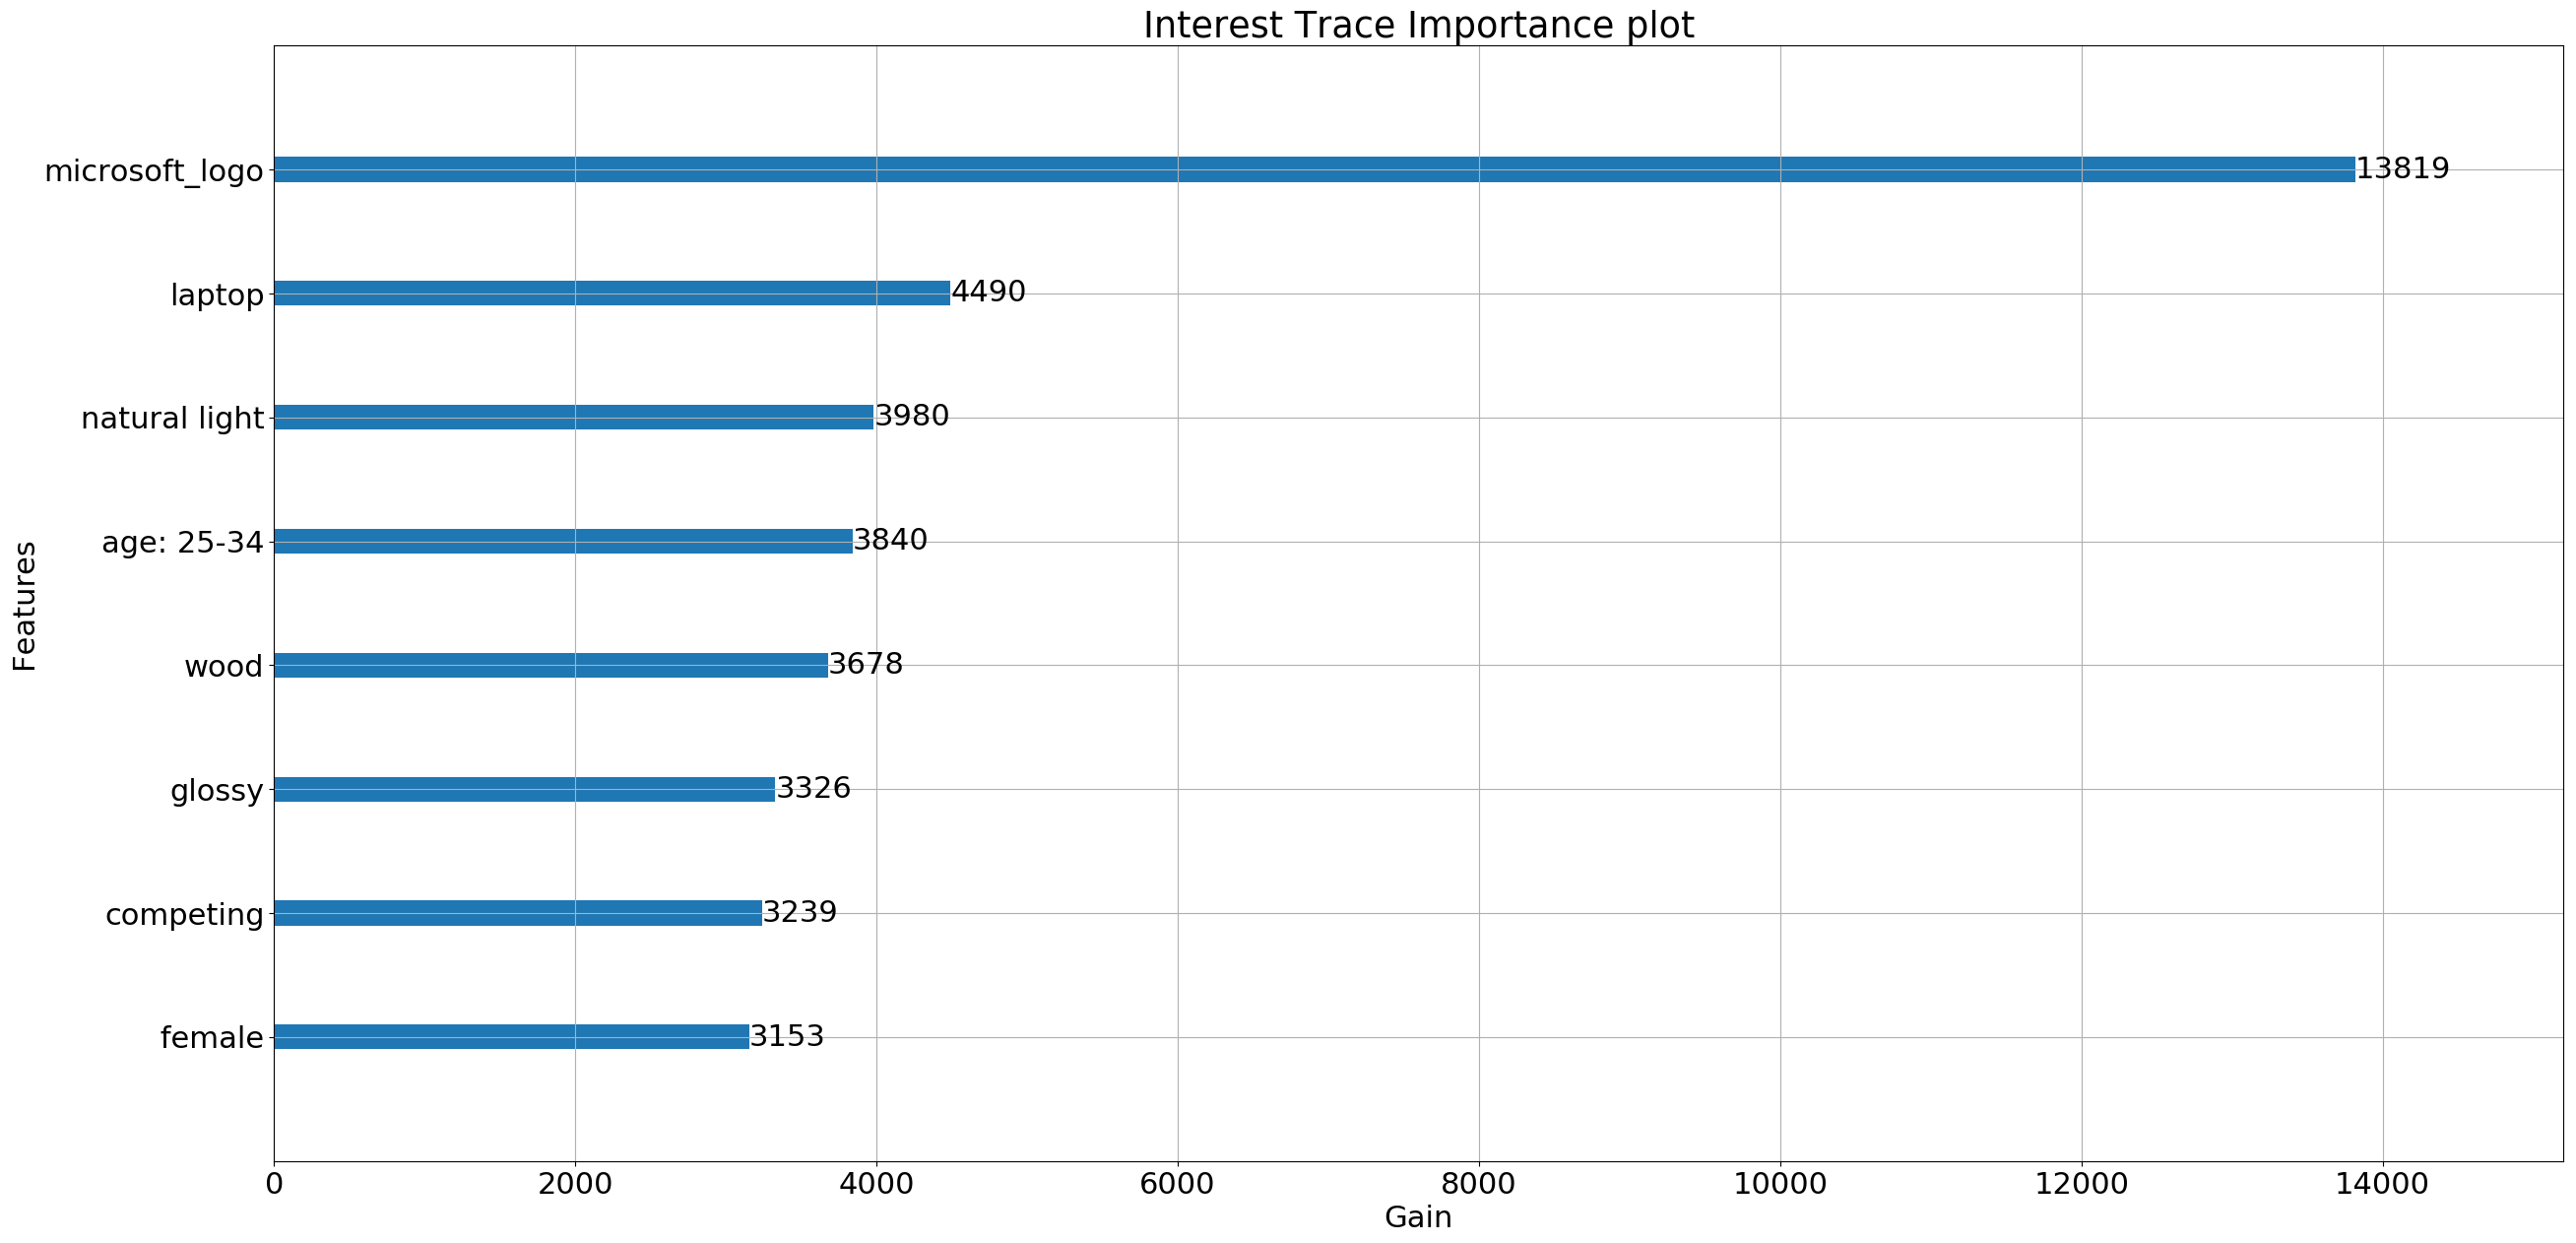

In [94]:
model_xgb.plot_feature_importance(trained_xgb,10,y_test.columns,X_test.columns.values[1:])

In [42]:
from sklearn.model_selection import GridSearchCV
parameters_tree={"colsample_bytree":[0.4,0.6],"max_depth":[6,8,13,15,20,50,100],"min_samples_leaf":[2,4],"n_estimators":[500,1000,2000,5000]}
grd = GridSearchCV(model_xgb.model,param_grid=parameters_tree,cv=3,return_train_score=True,verbose=1,n_jobs=-1,scoring='r2')

In [43]:
# grd.fit(X_train.drop('Video Name',1),y_train['Interest Trace'])

In [42]:
for i in range(30):
    print("True Value: ",round(y_test.values[i:i+1,0][0],2),"Predicted Value:",round(model_rf.predict(X_test.iloc[i:i+1]).values[0,0],2),)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

True Value:  16.4 Predicted Value: 17.81
True Value:  17.31 Predicted Value: 18.62
True Value:  10.04 Predicted Value: 10.89
True Value:  23.14 Predicted Value: 19.41
True Value:  24.29 Predicted Value: 19.94
True Value:  1.01 Predicted Value: 2.29
True Value:  18.27 Predicted Value: 19.04
True Value:  5.78 Predicted Value: 8.58
True Value:  20.11 Predicted Value: 16.69
True Value:  25.28 Predicted Value: 23.24
True Value:  11.85 Predicted Value: 11.4
True Value:  0.0 Predicted Value: 16.45
True Value:  2.51 Predicted Value: 2.78
True Value:  22.4 Predicted Value: 22.75


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

True Value:  21.92 Predicted Value: 22.64
True Value:  21.91 Predicted Value: 21.05
True Value:  8.5 Predicted Value: 9.13
True Value:  19.06 Predicted Value: 13.32
True Value:  20.47 Predicted Value: 22.2
True Value:  30.61 Predicted Value: 27.86
True Value:  23.13 Predicted Value: 22.07
True Value:  28.36 Predicted Value: 22.7
True Value:  19.49 Predicted Value: 21.5
True Value:  8.66 Predicted Value: 13.54
True Value:  15.15 Predicted Value: 16.53
True Value:  19.0 Predicted Value: 19.28
True Value:  20.92 Predicted Value: 20.65
True Value:  8.72 Predicted Value: 6.85
True Value:  22.12 Predicted Value: 21.99
True Value:  0.0 Predicted Value: 2.24


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished


In [43]:
from sklearn.linear_model import LinearRegression,LassoCV,BayesianRidge
from sklearn.metrics import r2_score

In [83]:
lr = LinearRegression(normalize=False)
lasso_cv = LassoCV(verbose=True)
br = BayesianRidge(n_iter=1000)

In [84]:
lr = lr.fit(X_train.drop('Video Name',1),y_train['Interest Trace'])
lasso_cv = lasso_cv.fit(X_train.drop('Video Name',1),y_train['Interest Trace'])
br = br.fit(X_train.drop('Video Name',1),y_train['Interest Trace'])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
............................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s finished


In [85]:
print("Linear Regression Model",r2_score(y_test['Interest Trace'],lr.predict(X_test.drop('Video Name',1))))
print("Lasso Model",r2_score(y_test['Interest Trace'],lasso_cv.predict(X_test.drop('Video Name',1))))
print("Bayesian Ridge",r2_score(y_test['Interest Trace'],br.predict(X_test.drop('Video Name',1))))
print("XGB Model",r2_score(y_test['Interest Trace'],model_xgb.predict(X_test.drop('Video Name',1))))
print("RF Model",r2_score(y_test['Interest Trace'],model_rf.predict(X_test.drop('Video Name',1))))

Linear Regression Model -7214540.581494744
Lasso Model 0.6033941132404363
Bayesian Ridge 0.6029630667030705
XGB Model 0.7434742427950406
RF Model 0.735182424961871


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.1s finished


In [47]:
shap.initjs()
explainer_rf= shap.TreeExplainer(trained_rf[0])
shap_values_rf= explainer_rf.shap_values(X_train.drop('Video Name',1))

In [49]:
explainer_xgb = shap.TreeExplainer(trained_xgb[0])
shap_values_xgb= explainer_xgb.shap_values(X_train.drop('Video Name',1))

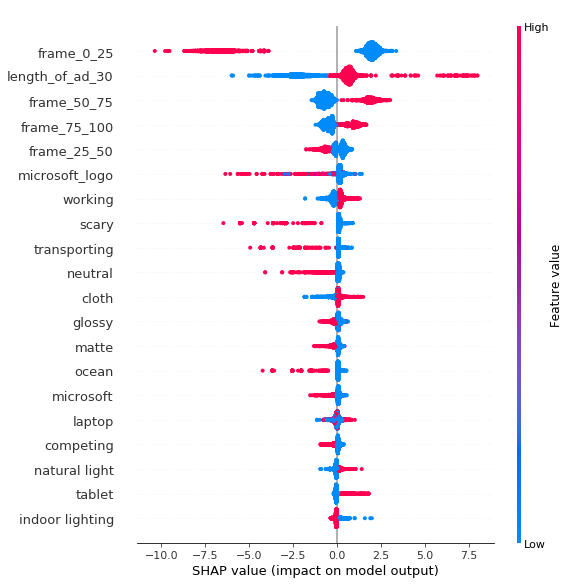

In [48]:
shap.summary_plot(shap_values_rf,X_train.drop('Video Name',1))

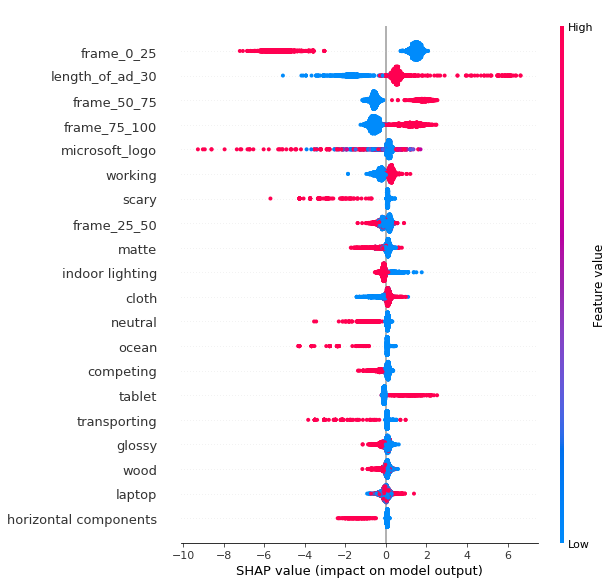

In [50]:
shap.summary_plot(shap_values_xgb,X_train.drop('Video Name',1))

# NN

In [51]:
import keras
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras import backend as K
from keras.regularizers import l2

Using TensorFlow backend.


In [57]:
def model_nn():
    model = Sequential()
    model.add(Dense(512,input_shape=(158,),activation='relu',kernel_initializer='normal'))
    model.add(Dense(256,activation='relu',kernel_initializer='normal'))
    model.add(Dense(256,activation='relu',kernel_initializer='normal'))
    
#     model.add(Dropout(0.4))
    model.add(Dense(128,activation='relu',kernel_initializer='normal'))
    model.add(Dense(128,activation='relu',kernel_initializer='normal'))
#     model.add(Dropout(0.3))
    model.add(Dense(64,activation='relu',kernel_initializer='normal'))
    model.add(Dense(1,activation='linear',kernel_initializer='normal'))
    
    return model

In [58]:
def r2_keras(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [59]:
model = model_nn()
model.compile(optimizer='adam',loss="mean_squared_error",metrics=[r2_keras])

In [60]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 512)               81408     
_________________________________________________________________
dense_9 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_10 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_11 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_12 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_13 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 65        
Total para

In [61]:
X_train_nn,X_test_nn,y_train_nn,y_test_nn = train_test_split(X_new,Y,test_size=0.3,random_state=123)

In [62]:
history = model.fit(X_train_nn.drop('Video Name',1).values,y_train_nn.values,epochs=10,verbose=1,validation_data=(X_test_nn.drop('Video Name',1).values,y_test_nn.values))

Instructions for updating:
Use tf.cast instead.
Train on 3731 samples, validate on 1600 samples
Epoch 1/100
3731/3731 [==============================] - 1s 232us/step - loss: 72.3118 - r2_keras: -0.3440 - val_loss: 24.1802 - val_r2_keras: 0.5603
Epoch 2/100
3731/3731 [==============================] - 1s 137us/step - loss: 22.1406 - r2_keras: 0.5932 - val_loss: 21.5102 - val_r2_keras: 0.6063
Epoch 3/100
3731/3731 [==============================] - 1s 143us/step - loss: 18.9290 - r2_keras: 0.6475 - val_loss: 19.9845 - val_r2_keras: 0.6348
Epoch 4/100
3731/3731 [==============================] - 1s 139us/step - loss: 17.9328 - r2_keras: 0.6639 - val_loss: 19.4118 - val_r2_keras: 0.6450
Epoch 5/100
3731/3731 [==============================] - 1s 136us/step - loss: 15.1532 - r2_keras: 0.7147 - val_loss: 17.5667 - val_r2_keras: 0.6809
Epoch 6/100
3731/3731 [==============================] - 1s 137us/step - loss: 14.4629 - r2_keras: 0.7318 - val_loss: 25.6381 - val_r2_keras: 0.5204
Epoch 7/1

Epoch 54/100
3731/3731 [==============================] - 1s 140us/step - loss: 5.6953 - r2_keras: 0.8933 - val_loss: 17.3069 - val_r2_keras: 0.6902
Epoch 55/100
3731/3731 [==============================] - 1s 139us/step - loss: 5.9946 - r2_keras: 0.8877 - val_loss: 16.5793 - val_r2_keras: 0.7010
Epoch 56/100
3731/3731 [==============================] - 1s 135us/step - loss: 5.3422 - r2_keras: 0.9031 - val_loss: 16.1994 - val_r2_keras: 0.7114
Epoch 57/100
3731/3731 [==============================] - 1s 134us/step - loss: 5.4284 - r2_keras: 0.8977 - val_loss: 16.2922 - val_r2_keras: 0.7081
Epoch 58/100
3731/3731 [==============================] - 1s 140us/step - loss: 5.5667 - r2_keras: 0.8966 - val_loss: 17.1146 - val_r2_keras: 0.6958
Epoch 59/100
3731/3731 [==============================] - 1s 142us/step - loss: 5.6989 - r2_keras: 0.8883 - val_loss: 16.6515 - val_r2_keras: 0.7024
Epoch 60/100
3731/3731 [==============================] - 1s 153us/step - loss: 5.2900 - r2_keras: 0.9004 

In [159]:
for i,val in enumerate(model.predict(X_test.drop('Video Name',1).values)):
#     print(round(y_test.values[i][0],2),round(val[0],2))
    pass

In [63]:
model.evaluate(X_test.drop('Video Name',1).values,y_test.values)

1600/1600 [==============================] - 0s 35us/step


[16.548707275390626, 0.7051092147827148]

In [64]:
import matplotlib.pyplot as plt

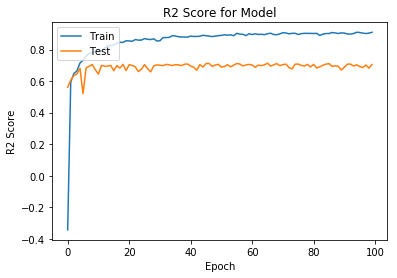

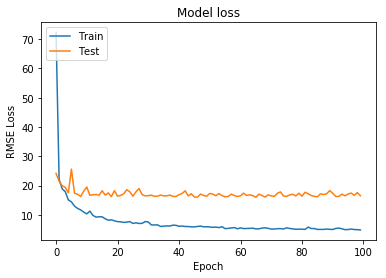

In [65]:
plt.plot(history.history['r2_keras'])
plt.plot(history.history['val_r2_keras'])
plt.title('R2 Score for Model')
plt.ylabel('R2 Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('RMSE Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [250]:
import lightgbm as lgbm

In [260]:
params={'objective':'rmse','num_leaves':50,'seed':0,'metric':['mse']}
train_data = lgbm.Dataset(X_train.drop('Video Name',1), label=y_train[['Interest Trace']])
model = lgbm.train(params,train_data,2000,verbose_eval=1)

In [261]:
r2_score(y_test[['Interest Trace']],model.predict(X_test.drop('Video Name',1)))

0.7934034076938773